<a href="https://colab.research.google.com/github/connect-midhunr/rossmann-sales-prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Business Task

Build a machine learning model to forecast the sales of each Rossmann store upto 6 weeks. This is undertaken as an individual project.

# Importing Libraries and Defining Functions

In [1]:
# importing all relevant python libraries
import warnings
warnings.filterwarnings("ignore")

import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# define a fubction to find the number and percentage of missing values in a dataframe
def get_missing_values_count_and_percentage(dataframe):
  num = 0
  for column in dataframe.columns:
    count = dataframe[column].isnull().sum()
    percentage = count/dataframe.shape[0]*100
    if percentage > 0:
      num += 1
      print(f"{column}: {count}({round(percentage, 2)})%")
  if num == 0:
    print("No missing values in the dataframe")

In [3]:
# define a function to calculate the upper and lower outlier boundary
# returns a tuple (upper_outlier_bound, lower_outlier_bound)
def get_outlier_boundaries(dataframe, column):
  percentile_25 = np.nanpercentile(dataframe[column],25)
  percentile_75 = np.nanpercentile(dataframe[column],75)
  iqr = (percentile_75 - percentile_25)
  upper_outlier_bound = percentile_75 + 1.5*iqr
  lower_outlier_bound = percentile_25 - 1.5*iqr

  return (upper_outlier_bound, lower_outlier_bound)

# define a function to calculate the number and percentage of outliers in a column
# returns a tuple (count, percentage)
def get_outlier_count_and_percentage(dataframe, column):
  # print(dataframe.shape[0])
  upper_outlier_bound, lower_outlier_bound = get_outlier_boundaries(dataframe, column)

  count = 0
  for value in dataframe[column]:
    if value > upper_outlier_bound or value < lower_outlier_bound:
      count += 1
  percentage = round(count/dataframe.shape[0]*100, 2)

  return (count, percentage)

In [4]:
# define a function to get count of each unique value from a particular column 
# returns a dataframe
def get_count_from_column(dataframe, column_label):
  df_grpd = dataframe[column_label].value_counts()
  df_grpd = pd.DataFrame({'index':df_grpd.index, 'count':df_grpd.values})
  return df_grpd

# define a function to get sum of a certain feature for each unique value from a particular column 
# returns a dataframe
def get_sum_from_column(dataframe, column_label, feature):
  df_grpd = dataframe.groupby(column_label)[feature].sum().reset_index(name=feature)
  return df_grpd

In [5]:
# define a function to calculate the vif of all features
# returns a dataframe
def calculate_vif_of_all_features(dataframe):
  temp_df = pd.DataFrame()
  temp_df['Feature'] = dataframe.columns
  temp_df['VIF'] = [variance_inflation_factor(dataframe.values, column_index) for column_index in range(dataframe.shape[1])]

  return temp_df

In [6]:
# define a function to calculate root mean squared percentage error
# returns an array
def calculate_rmspe(y_actual, y_pred):
  return (np.sqrt(np.mean(np.square(y_actual.to_numpy() - y_pred))) / np.mean(y_actual.to_numpy())) * 100

In [7]:
# define a function to calculate metrics
# returns a dictionary
def calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred):
  metrics_dict = {}

  metrics_dict['Train_R2'] = r2_score(y_train, y_train_pred)
  metrics_dict['Test_R2'] = r2_score(y_test, y_test_pred)
  metrics_dict['Train_RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
  metrics_dict['Test_RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
  metrics_dict['Train_RMSPE'] = calculate_rmspe(y_train, y_train_pred)
  metrics_dict['Test_RMSPE'] = calculate_rmspe(y_test, y_test_pred)

  return metrics_dict

In [8]:
# define a function to generate horizontal box plot
# prints a box plot
def generate_horizontal_box_plot(dataframe, x_feature, y_feature=None):
  sns.set_theme(rc={'figure.figsize': (8,4)},style='whitegrid',palette='muted')
  if y_feature != None:
    ax = sns.boxplot(x=dataframe[x_feature], y=dataframe[y_feature])
  else:
    ax = sns.boxplot(x=dataframe[x_feature], y=None)
  ax.grid(False)

# define a function to generate vertical box plot
# prints a box plot
def generate_vertical_box_plot(dataframe, y_feature, x_feature=None):
  sns.set_theme(rc={'figure.figsize': (4,8)},style='whitegrid',palette='muted')
  if x_feature != None:
    ax = sns.boxplot(y=dataframe[y_feature], x=dataframe[x_feature])
  else:
    ax = sns.boxplot(y=dataframe[y_feature], x=None)
  ax.grid(False)

In [9]:
# define a function to plot a pie chart
# prints a pie chart
def plot_pie_chart_from_column(dataframe, x_feature, y_feature):
  fig, ax = plt.subplots(figsize=(14, 6))
  ax.pie(dataframe.loc[:, x_feature], labels=dataframe.loc[:, y_feature], autopct='%1.2f%%', startangle=90)
  ax.axis('equal')
  plt.show()

# define a function to plot a pie chart from grouped data
# prints a pie chart
def plot_pie_chart_from_column_count(dataframe, column_label):
  df_grpd = get_count_from_column(dataframe, column_label)
  plot_pie_chart_from_column(df_grpd, 'count', 'index')

In [10]:
# define a function to plot bar graph with two features
# prints a bar graph
def plot_bar_graph_with_two_features(dataframe, x_feature, y_feature):
  if type(y_feature) == list:
    size = len(y_feature)
    fig, axes = plt.subplots(1, size, figsize=(10*size, 6))
    column = -1
    for feature in y_feature:
      column += 1
      sns.barplot(ax=axes[column], x=dataframe[x_feature], y=dataframe[feature], estimator=sum)
      axes[column].set_title(f"Sum of {feature} vs {x_feature}")
  else:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=dataframe[x_feature], y=dataframe[y_feature], estimator=sum)
    ax.set_title(f"Sum of {y_feature} vs {x_feature}")
    plt.show()

In [11]:
# define a function to plot bar graph with three features
# prints a bar graph
def plot_bar_graph_with_three_features(dataframe, x_feature, y_feature, z_feature, y_label):
  plt.figure(figsize=(20, 10))

  X = dataframe[x_feature].tolist()
  Y = dataframe[y_feature].tolist()
  Z = dataframe[z_feature].tolist()
    
  X_axis_length = np.arange(len(X))
    
  plt.bar(X_axis_length - 0.2, Y, 0.4, label = y_feature)
  plt.bar(X_axis_length + 0.2, Z, 0.4, label = z_feature)
    
  plt.xticks(X_axis_length, X)
  plt.xlabel(x_feature)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

In [12]:
# define a function to plot line graph with dot markers over time
# prints a line graph
def plot_line_graph_with_two_features_over_time(dataframe, x_feature, y_feature, time, title):
  # unique year values in time
  times = rossmann_df[time].unique().tolist()

  # list of random colors to use in the graph
  num_of_colors = len(times)
  list_of_colors = color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
                                                                         for j in range(num_of_colors)]
  # plot each line graph                                                                       
  color_num = -1
  plt.figure(figsize=(24, 6))
  for ind_time in times:
    color_num += 1
    temp_df = rossmann_df[rossmann_df[time] == ind_time]
    temp_df = temp_df.groupby(x_feature)[y_feature].sum().reset_index()
    plt.plot(temp_df.loc[:,y_feature], label=ind_time, color=list_of_colors[color_num], marker='o')
    plt.xticks(range(1, dataframe[x_feature].max() + 1))
  plt.title(f'{title} {y_feature} Over {time}s')
  plt.legend()

In [13]:
# generate scatter plots to check the linearity between sales and customers for each unique value in a feature
# plots scatter plots
def scatter_plot_bw_sales_customers_with_feature_unique_values(dataframe, feature):
  unique_values = sorted(rossmann_df[feature].unique().tolist())

  rows_num = math.ceil(len(unique_values)/2)
  columns_num = 2
  fig, axes = plt.subplots(rows_num, columns_num, figsize=(20, 8*rows_num))

  row = -1
  column = columns_num - 1
  for unique_value in unique_values:
    if column == (columns_num - 1):
      row += 1
      column = 0
    else:
      column += 1
    temp_df = dataframe[dataframe[feature] == unique_value]
    sns.scatterplot(ax=axes[row, column], x='Customers', y='Sales', data=temp_df)
    lin_fit = np.polyfit(temp_df['Customers'], temp_df['Sales'], 1)
    lin_func = np.poly1d(lin_fit)(temp_df['Customers'])
    axes[row, column].plot(temp_df['Customers'], lin_func, "r--", lw=1)
    axes[row, column].set_title(f"Sales vs Customers for {unique_value}\nCorrelation = {round(temp_df['Customers'].corr(temp_df['Sales'])*100, 2)}%")
  
  if len(unique_values) % 2 != 0:
    fig.delaxes(axes[rows_num - 1][1])

# Data Reading

In [14]:
# mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# creating dataframes and store csv data

sales_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Supervised Machine Learning - Regression/Rossmann Sales Prediction - Midhun R/Data & Resources/Rossmann Stores Data.csv')
store_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Supervised Machine Learning - Regression/Rossmann Sales Prediction - Midhun R/Data & Resources/store.csv')

# Data Inspection

Two datasets are given: store data and sales data. These two datasets should be merged after data cleaning and 'Sales' will be taken as the target feature.

## Store Data

In [16]:
# exploring the head of the store dataframe

store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [17]:
# exploring the tail of store dataframe

store_df.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [18]:
# looking into a brief summary of store dataframe

store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [19]:
# total number of rows in store dataframe
num_of_rows = store_df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

# number of duplicate rows
num_of_dup_rows = store_df[store_df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 1115
No. of duplicate rows: 0


*   Store dataframe contains 1115 rows of data and has zero duplicate rows.

In [20]:
# exploring the columns of store dataframe

store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


*   Store dataframe contains 10 columns.
*   Six columns have missing values.
*   Some columns require conversion of datatypes. 
*   Additionally, new columns need to be added from existing ones to make analysis easier.

In [21]:
# unique values in each column of store dataframe

print(store_df.apply(lambda col: col.unique()))

Store                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
StoreType                                                         [c, a, d, b]
Assortment                                                           [a, c, b]
CompetitionDistance          [1270.0, 570.0, 14130.0, 620.0, 29910.0, 310.0...
CompetitionOpenSinceMonth    [9.0, 11.0, 12.0, 4.0, 10.0, 8.0, nan, 3.0, 6....
CompetitionOpenSinceYear     [2008.0, 2007.0, 2006.0, 2009.0, 2015.0, 2013....
Promo2                                                                  [0, 1]
Promo2SinceWeek              [nan, 13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0,...
Promo2SinceYear              [nan, 2010.0, 2011.0, 2012.0, 2009.0, 2014.0, ...
PromoInterval                [nan, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Ju...
dtype: object


## Sales Data

In [22]:
# exploring the head of the sales dataframe

sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [23]:
# exploring the tail of sales dataframe

sales_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [24]:
# looking into a brief summary of sales dataframe

sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [25]:
# total number of rows in sales dataframe
num_of_rows = sales_df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

# number of duplicate rows
num_of_dup_rows = sales_df[sales_df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 1017209
No. of duplicate rows: 0


*   Sales dataframe contains 1017209 rows of data and has zero duplicate rows.

In [26]:
# exploring the columns of sales dataframe

sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


*   Sales dataframe contains 9 columns.
*   No columns have missing values.
*   Some columns require conversion of datatypes. 

In [27]:
# unique values in each column of sales dataframe

print(sales_df.apply(lambda col: col.unique()))

Store            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
DayOfWeek                                    [5, 4, 3, 2, 1, 7, 6]
Date             [2015-07-31, 2015-07-30, 2015-07-29, 2015-07-2...
Sales            [5263, 6064, 8314, 13995, 4822, 5651, 15344, 8...
Customers        [555, 625, 821, 1498, 559, 589, 1414, 833, 687...
Open                                                        [1, 0]
Promo                                                       [1, 0]
StateHoliday                                       [0, a, b, c, 0]
SchoolHoliday                                               [1, 0]
dtype: object


# Data Cleaning

### Handle Missing Values

Six out of 10 columns in store data have missing values in them. They must be handled properly inorder to get an accurate result.

In [28]:
# finding the number and percentage of missing values in the store data
get_missing_values_count_and_percentage(store_df)

CompetitionDistance: 3(0.27)%
CompetitionOpenSinceMonth: 354(31.75)%
CompetitionOpenSinceYear: 354(31.75)%
Promo2SinceWeek: 544(48.79)%
Promo2SinceYear: 544(48.79)%
PromoInterval: 544(48.79)%


Number of outliers: 108
Percentage of outliers: 9.69%


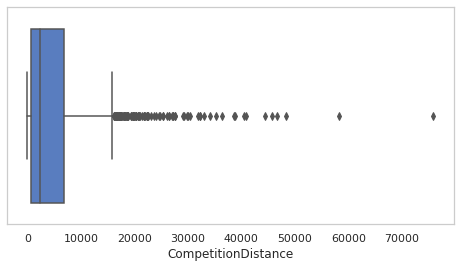

In [29]:
# create a box plot to show the distribution of values in CompetitionDistance

generate_horizontal_box_plot(store_df, "CompetitionDistance")
outlier_count_CompetitionDistance, outlier_percentage_CompetitionDistance = get_outlier_count_and_percentage(store_df, "CompetitionDistance")
print(f"Number of outliers: {outlier_count_CompetitionDistance}")
print(f"Percentage of outliers: {outlier_percentage_CompetitionDistance}%")

Due to the presence of outliers, mode and median are more appropriate for imputing missing values than mean. We can go ahead with median.

In [30]:
# filling the missing values with median
store_df["CompetitionDistance"].fillna(value = store_df.CompetitionDistance.median(), inplace=True)

Both CompetitionOpenSinceMonth and CompetitionOpenSinceYear have the same number of missing values. This may mean that both the features have missing values in the same rows.

In [31]:
# check if CompetitionOpenSinceMonth and CompetitionOpenSinceYear have missing values in the same rows

count = 0
for index, row in store_df.iterrows():
  if np.isnan(row["CompetitionOpenSinceMonth"]) and np.isnan(row["CompetitionOpenSinceYear"]):
    count += 1

print(count)

354


So, both the features have missing values in the same rows. Now lets check if its related to CompetitionDistance.

In [32]:
# show CompetitionDistance, CompetitionOpenSinceMonth and CompetitionOpenSinceYear for rows
# where CompetitionOpenSinceMonth and CompetitionOpenSinceYear have missing values

store_df[np.isnan(store_df["CompetitionOpenSinceMonth"])].loc[:, ["CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
11,1070.0,NaN,NaN
12,310.0,NaN,NaN
15,3270.0,NaN,NaN
18,3240.0,NaN,NaN
21,1040.0,NaN,NaN
...,...,...,...
1095,1130.0,NaN,NaN
1099,540.0,NaN,NaN
1112,9260.0,NaN,NaN
1113,870.0,NaN,NaN


Since no useful information was obtained from the above process, lets impute missing values with the most frequent values.

In [33]:
# filling the missing values with mode
store_df["CompetitionOpenSinceMonth"].fillna(value = store_df.CompetitionDistance.mode()[0], inplace=True)
store_df["CompetitionOpenSinceYear"].fillna(value = store_df.CompetitionDistance.mode()[0], inplace=True)

Promo2SinceWeek, Promo2SinceYear and PromoInterval have the same number of missing values. This may mean that these features have missing values in the same rows.

In [34]:
# check if Promo2SinceWeek, Promo2SinceYear and PromoInterval have missing values in the same rows

count = 0
for index, row in store_df.iterrows():
  if np.isnan(row["Promo2SinceWeek"]) and np.isnan(row["Promo2SinceYear"]) and np.isnan(row["PromoInterval"]):
    count += 1

print(count)

544


So, these features have missing values in the same rows. Now lets check if its related to Promo2.

In [35]:
# show Promo2, Promo2SinceWeek, Promo2SinceYear and PromoInterval for rows
# where Promo2SinceWeek, Promo2SinceYear and PromoInterval have missing values

store_df[np.isnan(store_df["Promo2SinceWeek"])].loc[:, ["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]]

,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
5,0,NaN,NaN,NaN
6,0,NaN,NaN,NaN
...,...,...,...,...
1107,0,NaN,NaN,NaN
1109,0,NaN,NaN,NaN
1111,0,NaN,NaN,NaN
1112,0,NaN,NaN,NaN


Promo2 value of head and tail of the above dataframe is 0. Lets check whether missing values in Promo2SinceWeek, Promo2SinceYear and PromoInterval is due to 0 in Promo2.

In [36]:
# show the count of each unique value in Promo2
store_df["Promo2"].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

So, missing values in Promo2SinceWeek, Promo2SinceYear and PromoInterval is due to 0 in Promo2. Lets impute missing values with 0.

In [37]:
# filling the missing values with value 0
store_df["Promo2SinceWeek"].fillna(value = 0, inplace=True)
store_df["Promo2SinceYear"].fillna(value = 0, inplace=True)
store_df["PromoInterval"].fillna(value = 0, inplace=True)

In [38]:
# number and percentage of missing values in the store data
get_missing_values_count_and_percentage(store_df)

No missing values in the dataframe


### Merging Dataframes

In [39]:
# merge the two datasets on Store data
rossmann_df = sales_df.merge(right=store_df, on="Store", how="left")

In [40]:
# exploring the head of the resultant dataframe
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [41]:
get_missing_values_count_and_percentage(rossmann_df)

No missing values in the dataframe


### Conversion of Column Datatype

In [42]:
# datatypes of columns in merged dataframe
rossmann_df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [43]:
# date should be converted from object to datetime
rossmann_df['Date'] = pd.to_datetime(rossmann_df['Date'])

In [44]:
# unique values in StateHoliday
rossmann_df["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [45]:
# convert StateHoliday values to int
rossmann_df["StateHoliday"].replace({'0':0, 'a':1, 'b':1, 'c':1}, inplace=True)
rossmann_df["StateHoliday"].unique()

array([0, 1])

In [46]:
# convert CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear
# from float to int
rossmann_df = rossmann_df.astype({"CompetitionOpenSinceMonth":int, "CompetitionOpenSinceYear":int, "Promo2SinceWeek":int, "Promo2SinceYear":int})

### Manipulation of Columns

In [47]:
# split the date column into month and year

rossmann_df['WeekOfYear'] = rossmann_df['Date'].dt.week
rossmann_df['Month'] = rossmann_df['Date'].dt.month
rossmann_df['Year'] = rossmann_df['Date'].dt.year

# # create a new feature which shows the number of months passed since competition started
# rossmann_df['CompetitionOpenNumMonths'] = (rossmann_df['Year'] - rossmann_df['CompetitionOpenSinceYear']) * 12 + (rossmann_df['Month'] - rossmann_df['CompetitionOpenSinceMonth'])
# # create a new feature which shows the number of weeks passed since promo 2 started
# rossmann_df['Promo2NumWeeks'] = (rossmann_df['Year'] - rossmann_df['Promo2SinceYear']) * 52 + (rossmann_df['WeekOfYear'] - rossmann_df['Promo2SinceWeek'])

In [48]:
# exploring the head of the resultant dataframe
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeekOfYear,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9,2008,0,0,0,0,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9,2009,0,0,0,0,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4,2015,0,0,0,0,31,7,2015


# Exploratory Data Analysis

## Univariate Analysis

Lets find the percentage of each store type.

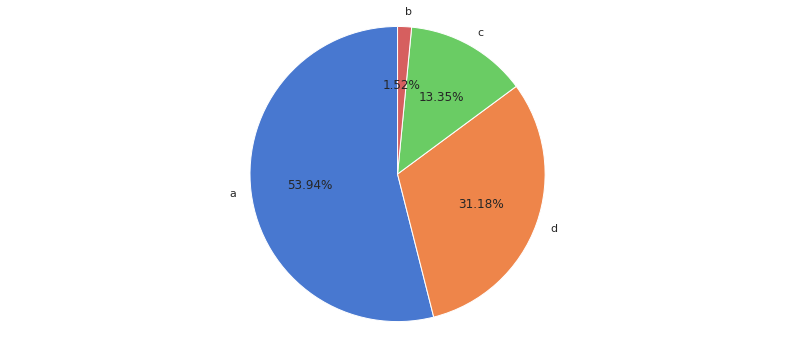

In [ ]:
# plot a pie chart to show % of store types
plot_pie_chart_from_column_count(rossmann_df.copy().loc[0:1115, ['Store', 'StoreType']], 'StoreType')

Store type a is the most common store type, followed by d, c and then b. Store type a takes up the majority share of all store types.

Lets find the percentage of each assortment.

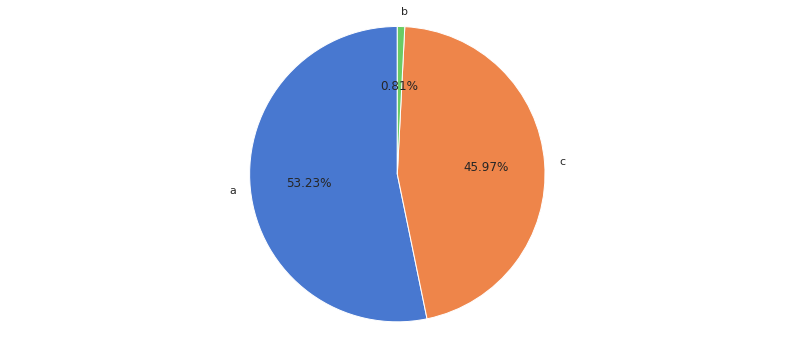

In [ ]:
# plot a pie chart to show % of assortments
plot_pie_chart_from_column_count(rossmann_df.copy().loc[0:1115, ['Store', 'Assortment']], 'Assortment')

Assortment a is the most common store type, followed by c and then b. Assortment a takes up the majority share of all assortments while assortment b comprises a negligible portion of the whole.

## Bivariate Analysis

Lets check the variation in sales with the number of customers.

Correlation between Sales and Customers = 89.47%


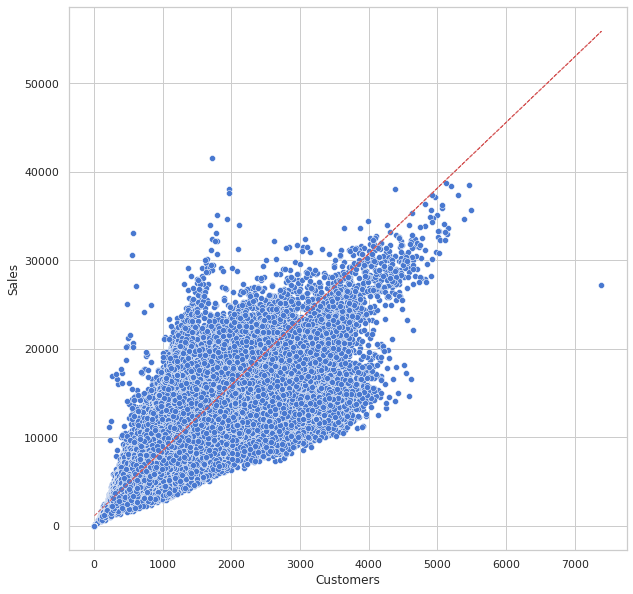

In [ ]:
# generate scatter plot to show the variation in sales with the number of customers
plt.figure(figsize=(10,10))
sns.scatterplot(x='Customers', y='Sales', data=rossmann_df)

lin_fit = np.polyfit(rossmann_df['Customers'], rossmann_df['Sales'], 1)
lin_func = np.poly1d(lin_fit)(rossmann_df['Customers'])
plt.plot(rossmann_df['Customers'], lin_func, "r--", lw=1)

print(f"Correlation between Sales and Customers = {round(rossmann_df['Customers'].corr(rossmann_df['Sales'])*100, 2)}%")

Relationship between sales and customers is almost linear. So we can safely say that as the number of customers increases, sales also increase.

Lets check how some categorical features like DayOfWeek, Promo, SchoolHoliday, etc. affect the sales and customers.

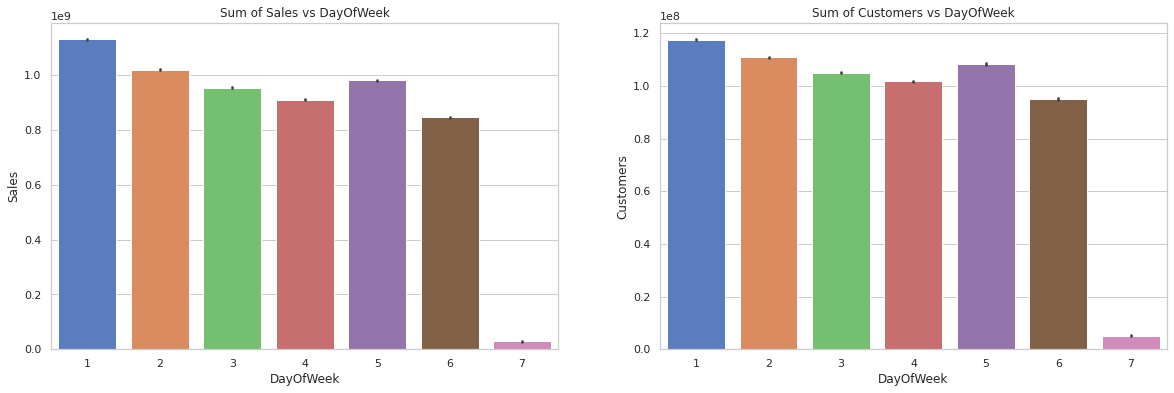

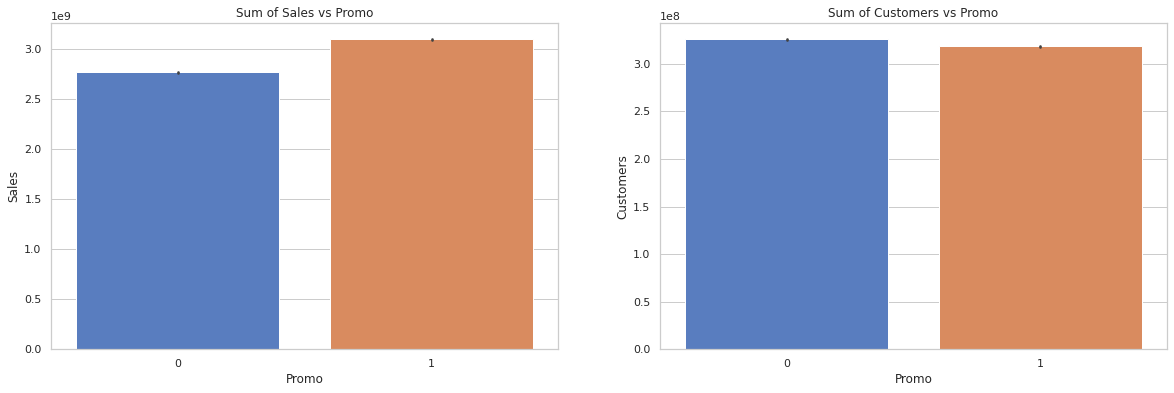

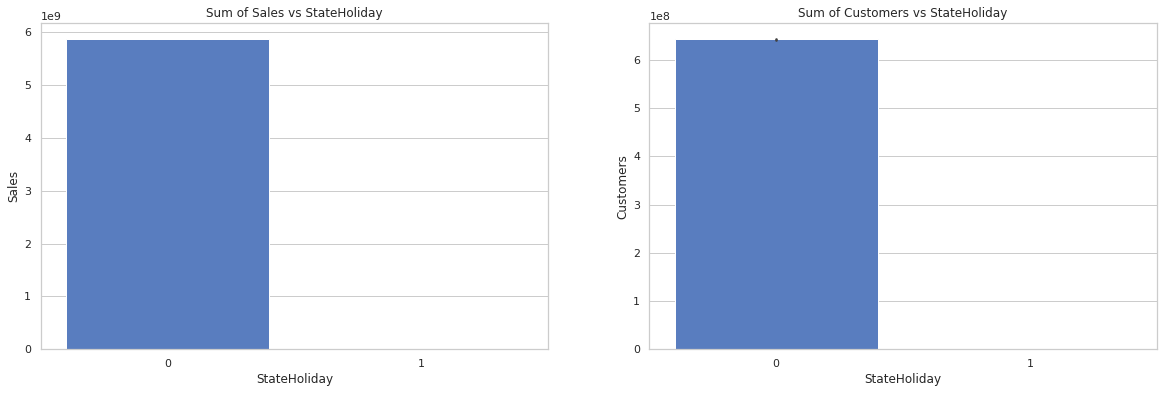

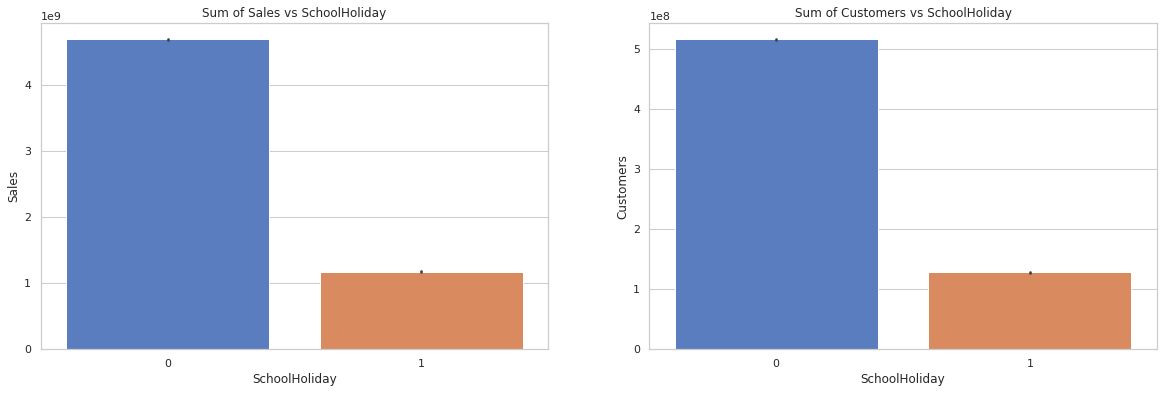

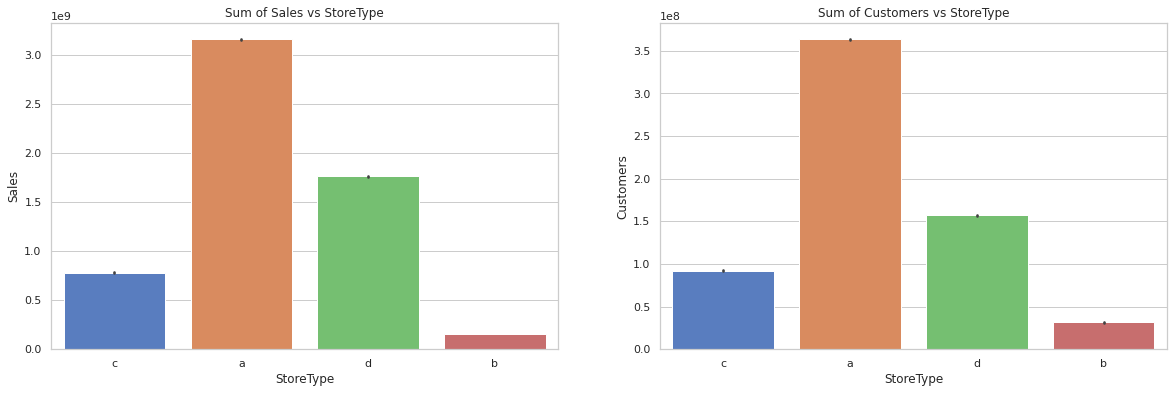

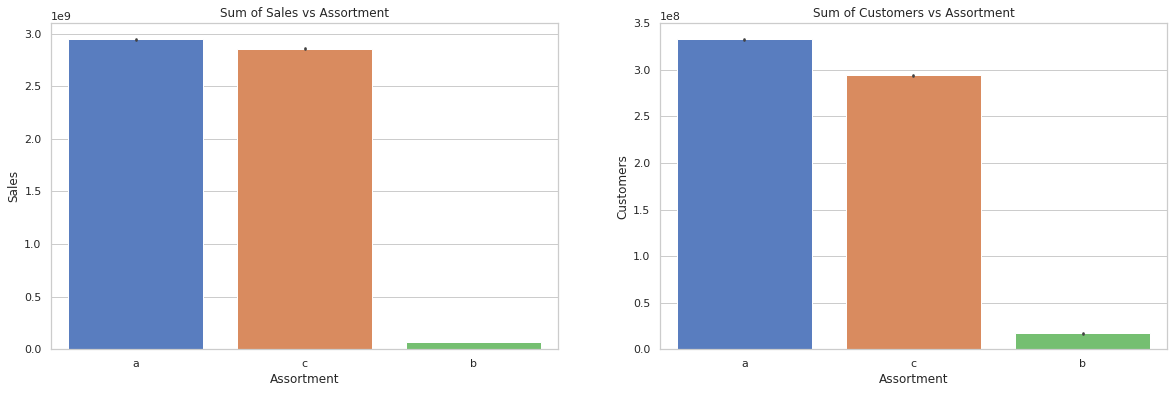

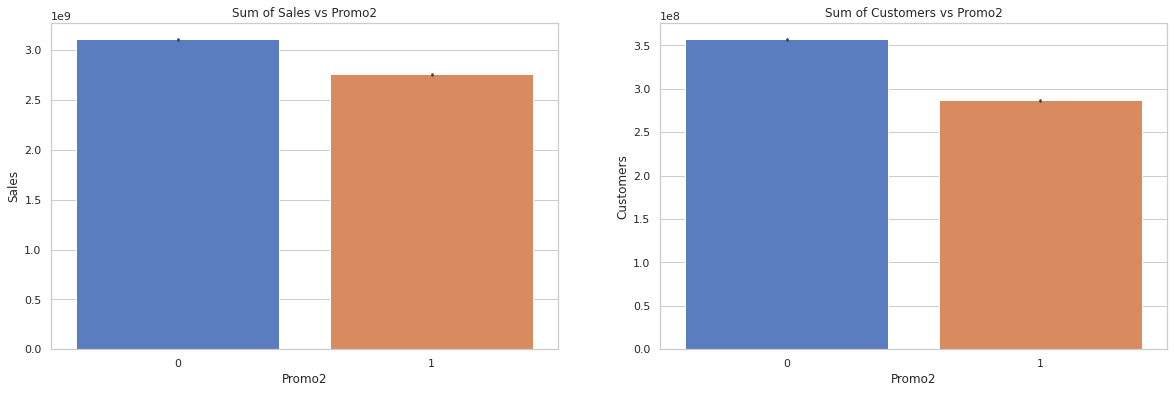

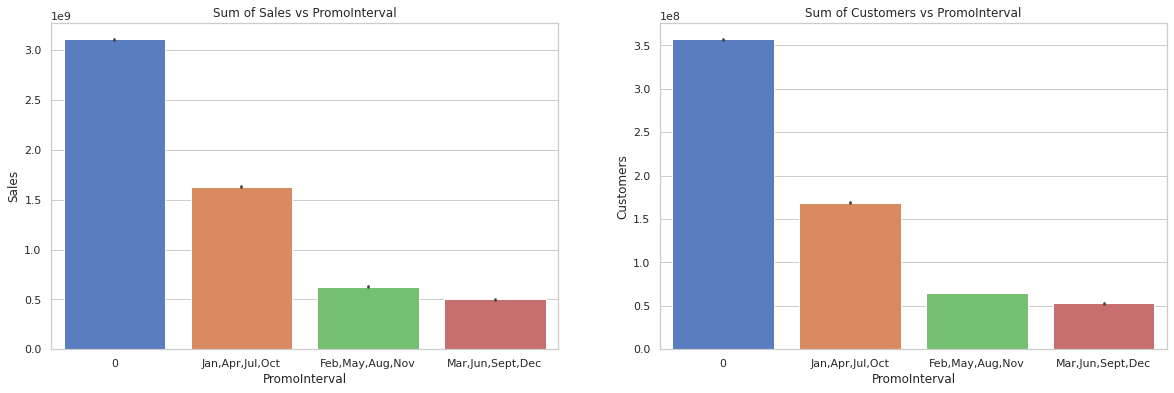

In [ ]:
# categotical variables under consideration
categorical_variables = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                         'StoreType', 'Assortment', 'Promo2', 'PromoInterval']

# plot bar graphs for each categorical variable against the sum of sales
for feature in categorical_variables:
  plot_bar_graph_with_two_features(rossmann_df, feature, ['Sales', 'Customers'])

The following observations were made from the above graphs:
*   Highest sales are recorded on Mondays and lowest sales are recorded on Sundays. This may be because most of the shops are closed on Sundays and this leads to higher demand on the next day, which is Monday.
*   Presence of promos increases sales, but it doesn't help much in generating new customers.
*   Shops are closed on all state holidays but sometimes some shops are opened during school holidays, which may be Saturdays.
*   Sales are higher on school holidays than other days.
*   Store type a records the most amount of sales and has more customers, mostly because the majority of the shops are type a.
*   Sales of assortment b is very rare and it has least customers.
*   Participants of promo 2 has less sales and customers, might be because it is seasonal and doesn't have any effect on sales and customers.
*   Promo interval Jan, Apr, Jul, Oct brings in more sales and customers.









Lets check which store type and assortment has the highest average sales and customer.

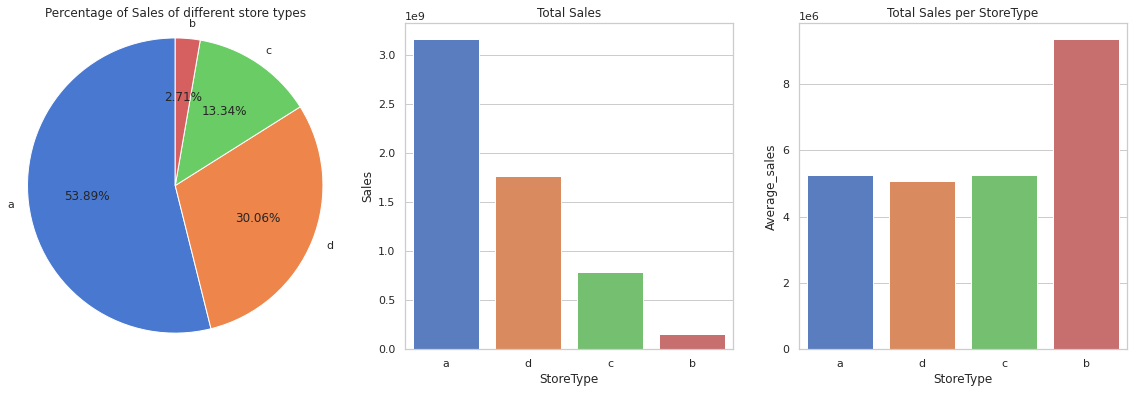

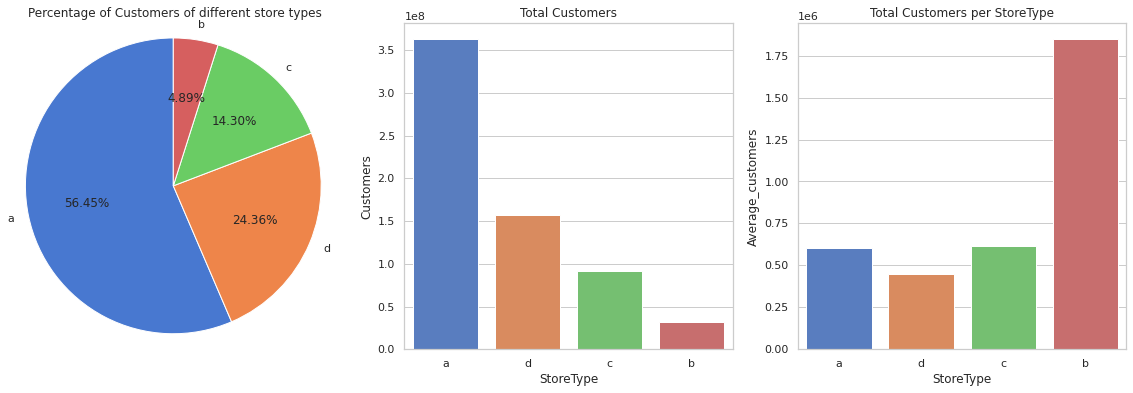

In [ ]:
# get a dataframe with count, sales, average sales, percentage sales, customers, average customers and percentage of customers of different store types
store_type_count_df = get_count_from_column(rossmann_df.copy().loc[0:1115, ['Store', 'StoreType']], 'StoreType').rename(columns={'index':'StoreType'})

store_type_sales_sum_df = get_sum_from_column(rossmann_df, 'StoreType', 'Sales')
store_type_df = store_type_count_df.merge(right=store_type_sales_sum_df, on='StoreType')
store_type_df['Percent_sales'] = round(store_type_df['Sales']/store_type_df['Sales'].sum()*100, 2)
store_type_df['Average_sales'] = round(store_type_df['Sales']/store_type_df['count'], 2)

store_type_customer_sum_df = get_sum_from_column(rossmann_df, 'StoreType', 'Customers')
store_type_df = store_type_df.merge(right=store_type_customer_sum_df, on='StoreType')
store_type_df['Percent_customers'] = round(store_type_df['Customers']/store_type_df['Customers'].sum()*100, 2)
store_type_df['Average_customers'] = round(store_type_df['Customers']/store_type_df['count'], 2)

for feature in ('Sales', 'Customers'):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  axes[0].pie(store_type_df.loc[:, feature], labels=store_type_df.loc[:, 'StoreType'], autopct='%1.2f%%', startangle=90)
  axes[0].axis('equal')
  axes[0].set_title(f"Percentage of {feature} of different store types")

  sns.barplot(ax=axes[1], x=store_type_df['StoreType'], y=store_type_df[feature])
  axes[1].set_title(f"Total {feature}")

  sns.barplot(ax=axes[2], x=store_type_df['StoreType'], y=store_type_df['Average_' + feature.lower()])
  axes[2].set_title(f"Total {feature} per StoreType")

  plt.show()

Even though the volume of sales and customers is low, store type b has the highest average sales and customers. This means store type b is more preferred by customers.

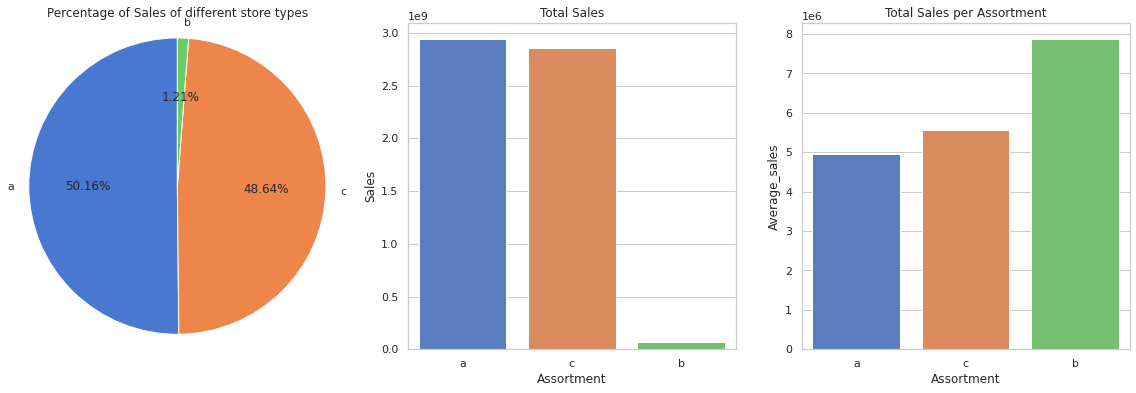

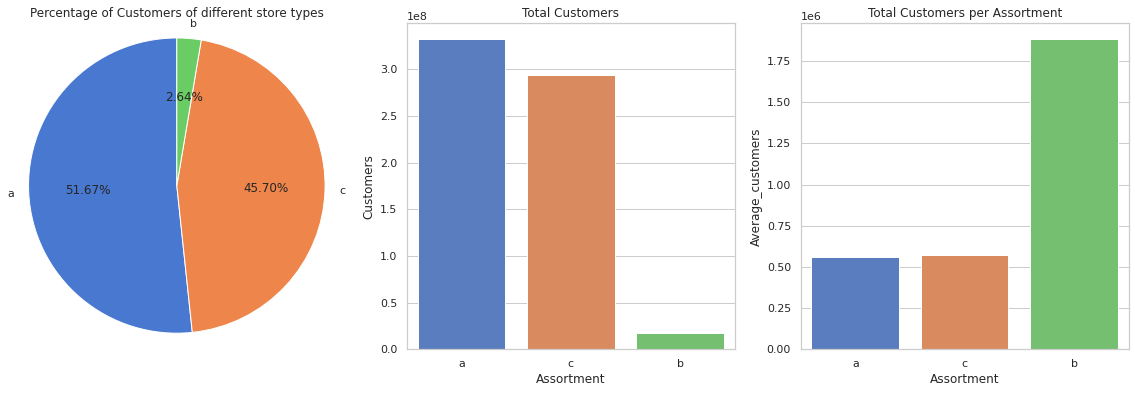

In [ ]:
# get a dataframe with count, sales, average sales, percentage sales, customers, average customers and percentage of customers of different assortments
assortment_count_df = get_count_from_column(rossmann_df.copy().loc[0:1115, ['Store', 'Assortment']], 'Assortment').rename(columns={'index':'Assortment'})

assortment_sales_sum_df = get_sum_from_column(rossmann_df, 'Assortment', 'Sales')
assortment_df = assortment_count_df.merge(right=assortment_sales_sum_df, on='Assortment')
assortment_df['Percent_sales'] = round(assortment_df['Sales']/assortment_df['Sales'].sum()*100, 2)
assortment_df['Average_sales'] = round(assortment_df['Sales']/assortment_df['count'], 2)

assortment_customer_sum_df = get_sum_from_column(rossmann_df, 'Assortment', 'Customers')
assortment_df = assortment_df.merge(right=assortment_customer_sum_df, on='Assortment')
assortment_df['Percent_customers'] = round(assortment_df['Customers']/assortment_df['Customers'].sum()*100, 2)
assortment_df['Average_customers'] = round(assortment_df['Customers']/assortment_df['count'], 2)

for feature in ('Sales', 'Customers'):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  axes[0].pie(assortment_df.loc[:, feature], labels=assortment_df.loc[:, 'Assortment'], autopct='%1.2f%%', startangle=90)
  axes[0].axis('equal')
  axes[0].set_title(f"Percentage of {feature} of different store types")

  sns.barplot(ax=axes[1], x=assortment_df['Assortment'], y=assortment_df[feature])
  axes[1].set_title(f"Total {feature}")

  sns.barplot(ax=axes[2], x=assortment_df['Assortment'], y=assortment_df['Average_' + feature.lower()])
  axes[2].set_title(f"Total {feature} per Assortment")

  plt.show()

Even though the volume of sales and customers is low, assortment b has the highest average sales and customers. This means assortment b is in high demand.

Lets check the number of sales for each assortment in different store types.

Text(0.5, 1.0, 'Number of Sales for each Assortment per Store Type')

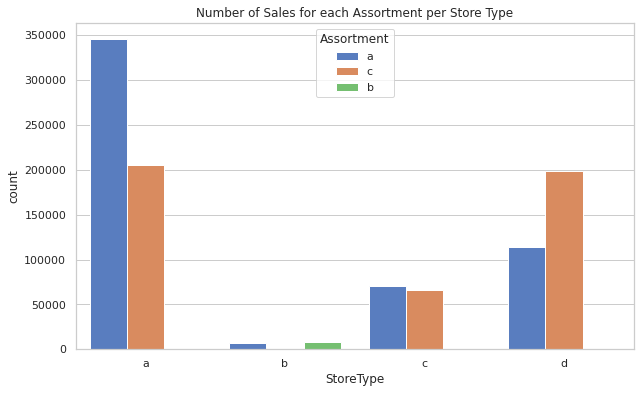

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='StoreType', hue='Assortment', order=sorted(rossmann_df['StoreType'].unique().tolist()), data=rossmann_df, palette=sns.color_palette(n_colors=3))
plt.title("Number of Sales for each Assortment per Store Type")

*   Only store type b sells assortment b and it has higher sales than assortment a. Assortment c is not sold in store type b.
*   Assortment a has more sales than c in store type a and d.
*   Assortment c has more sales than a in store type c.

Lets check how continous features like month, year, week, etc. affects the sales and customers.

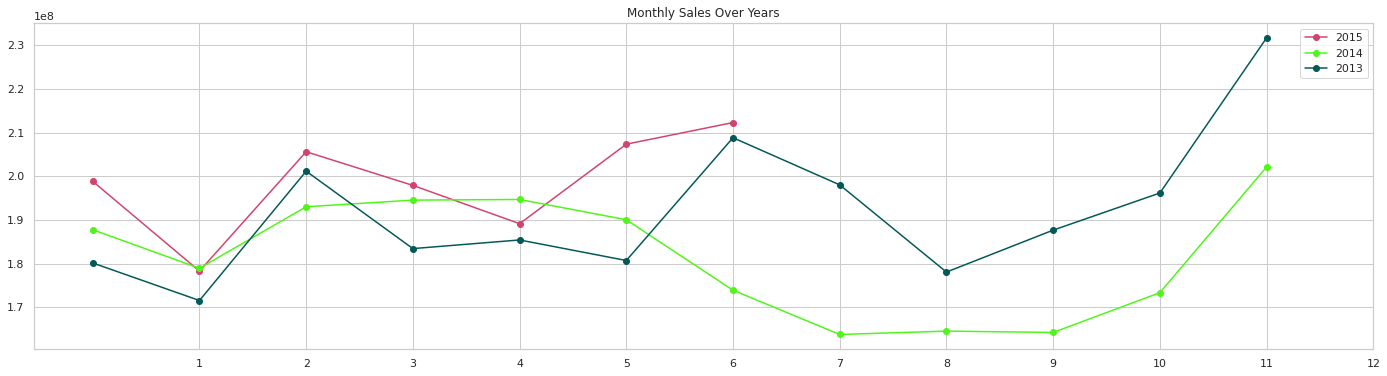

In [ ]:
# line graph of monthly sales over years
plot_line_graph_with_two_features_over_time(rossmann_df, 'Month', 'Sales', 'Year', 'Monthly')

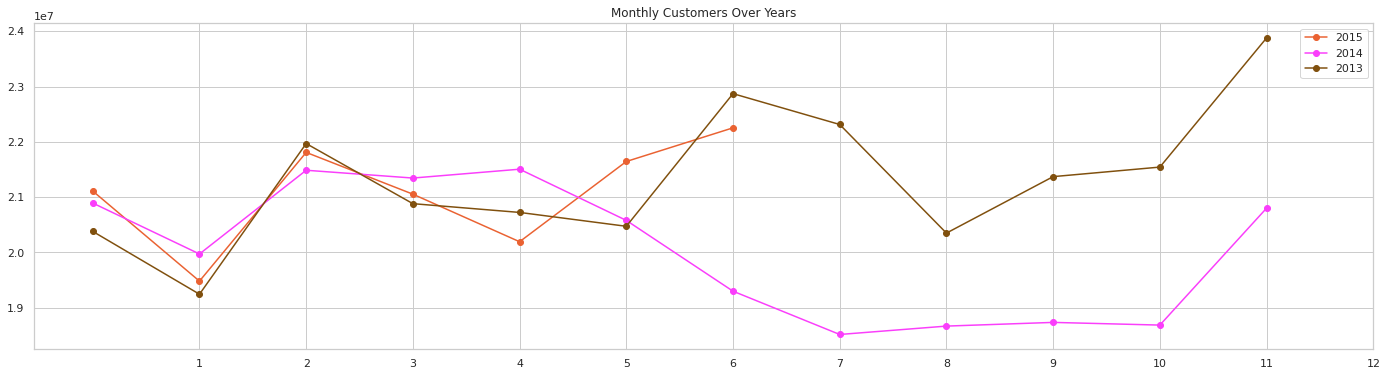

In [ ]:
# line graph of monthly customers over years
plot_line_graph_with_two_features_over_time(rossmann_df, 'Month', 'Customers', 'Year', 'Monthly')

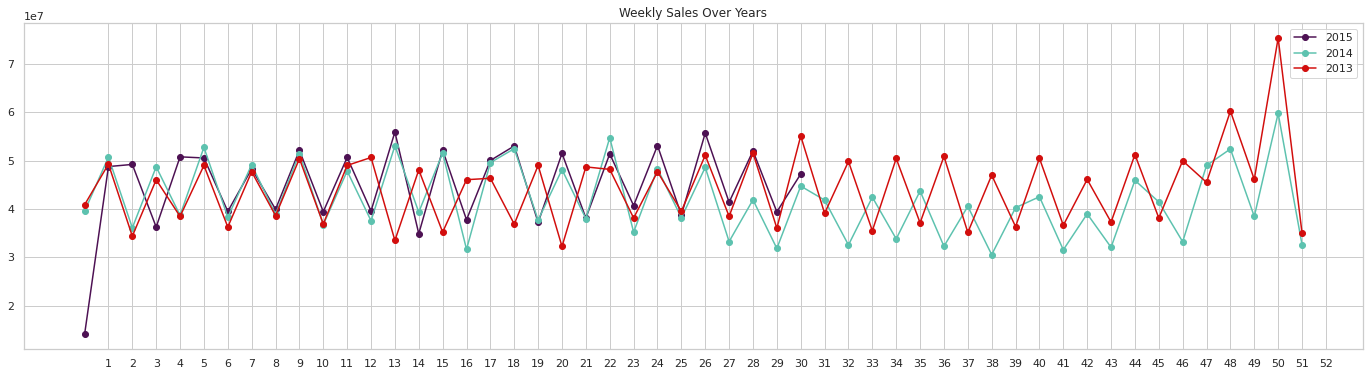

In [ ]:
# line graph of weekly sales over years
plot_line_graph_with_two_features_over_time(rossmann_df, 'WeekOfYear', 'Sales', 'Year', 'Weekly')

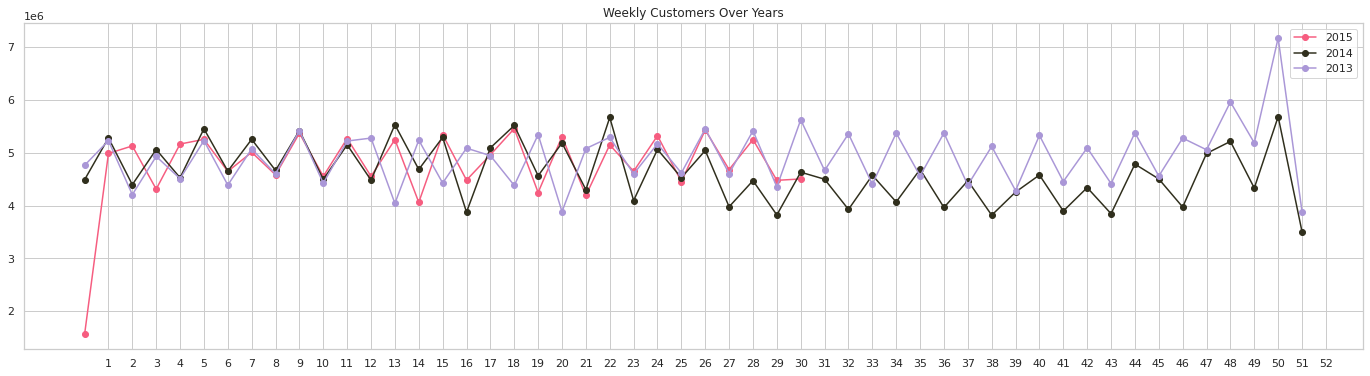

In [ ]:
# line graph of weekly customers over years
plot_line_graph_with_two_features_over_time(rossmann_df, 'WeekOfYear', 'Customers', 'Year', 'Weekly')

Weekly Sales and Customers are showing almost similar trends. Both peaks at mid-December.

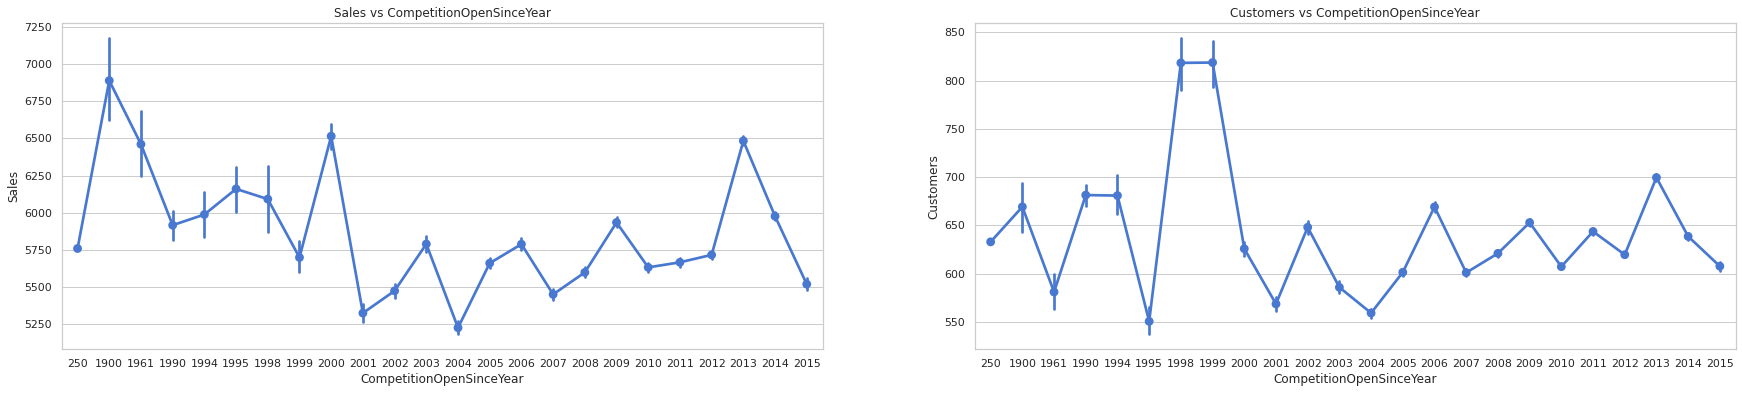

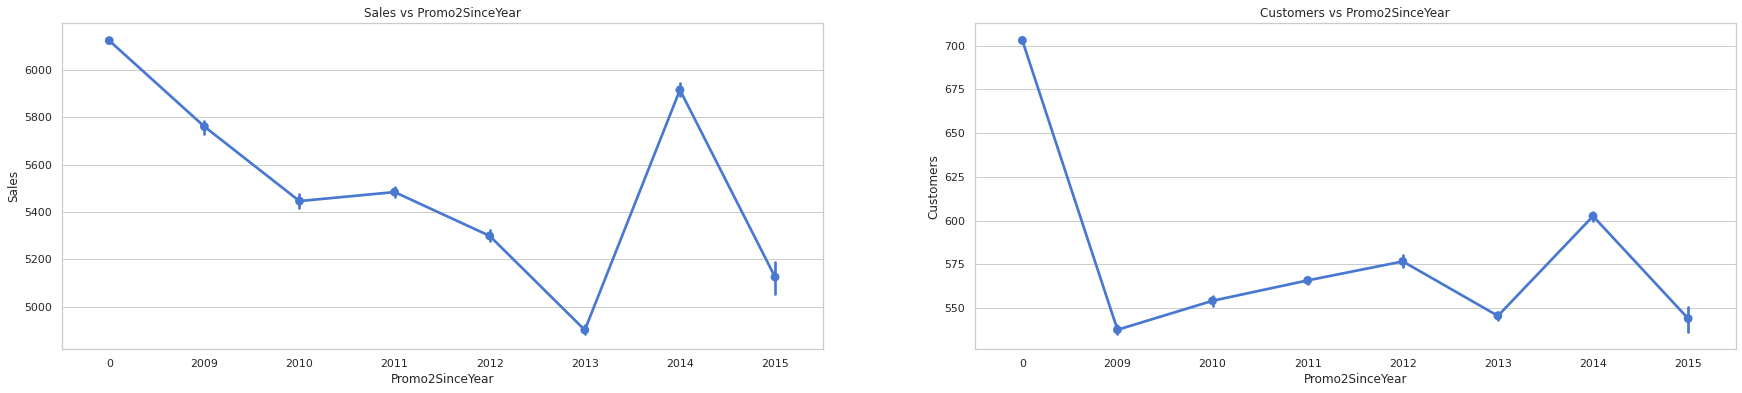

In [ ]:
# plot point plot for CompetitionOpenSinceYear & Promo2SinceYear
for feature in ('CompetitionOpenSinceYear', 'Promo2SinceYear'):
  fig, axes = plt.subplots(1, 2, figsize=(30,6))

  # plot point plot for Sales
  sns.pointplot(ax=axes[0], x=feature, y='Sales', data=rossmann_df)
  axes[0].set_title(f'Sales vs {feature}')

  # plot point plot for Customers
  sns.pointplot(ax=axes[1], x=feature, y='Customers', data=rossmann_df)
  axes[1].set_title(f'Customers vs {feature}')

Sales peaked at 1900 when a few stores were present so there was only a little competition. As years passed sales started to decline due to the increase in competition. But number of customers has peaked during late 1990s. Sales due to promo 2 is generally decreasing over the years, only exception in 2014.

Lets take a look at how Sales and customers change with competition distance.

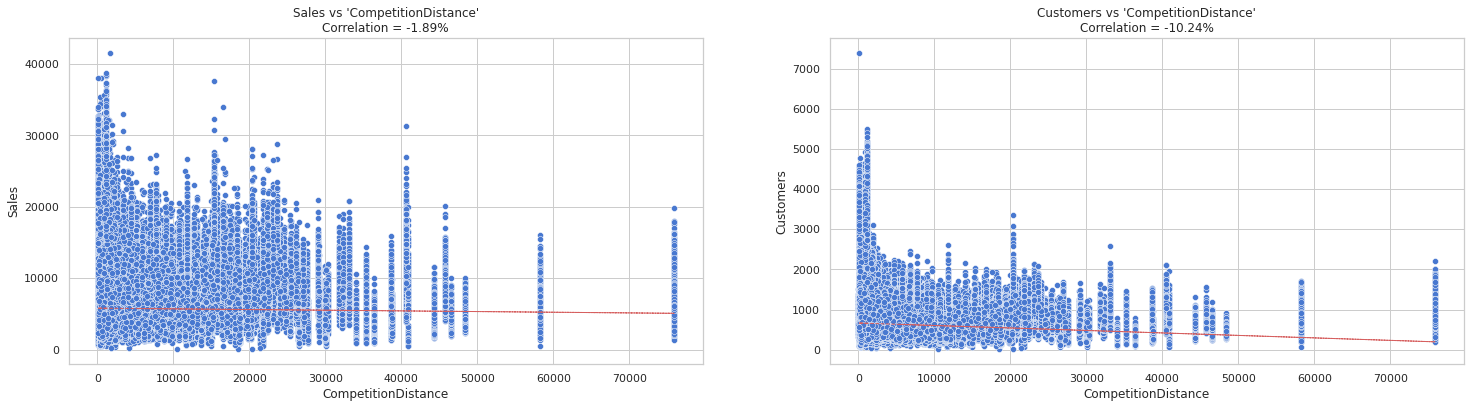

In [ ]:
# plot scatter plot for Sales & Customers against CompetitionDistance

column = -1
fig, axes = plt.subplots(1, 2, figsize = (25, 6))
for y_feature in ('Sales', 'Customers'):
  column += 1
  sns.scatterplot(ax=axes[column], x='CompetitionDistance', y=y_feature, data=rossmann_df[rossmann_df['Sales'] > 0])
  lin_fit = np.polyfit(rossmann_df['CompetitionDistance'], rossmann_df[y_feature], 1)
  lin_func = np.poly1d(lin_fit)(rossmann_df['CompetitionDistance'])
  axes[column].plot(rossmann_df['CompetitionDistance'], lin_func, "r--", lw=1)
  axes[column].set_title(f"{y_feature} vs 'CompetitionDistance'\nCorrelation = {round(rossmann_df['CompetitionDistance'].corr(rossmann_df[y_feature])*100, 2)}%")
plt.show()

Sales and customers decrease with increase in competition distance but they have very low correlation with competition distance.

## Correlationship Analysis

Lets visualize the relationship between various numerical data using correlation heat map.

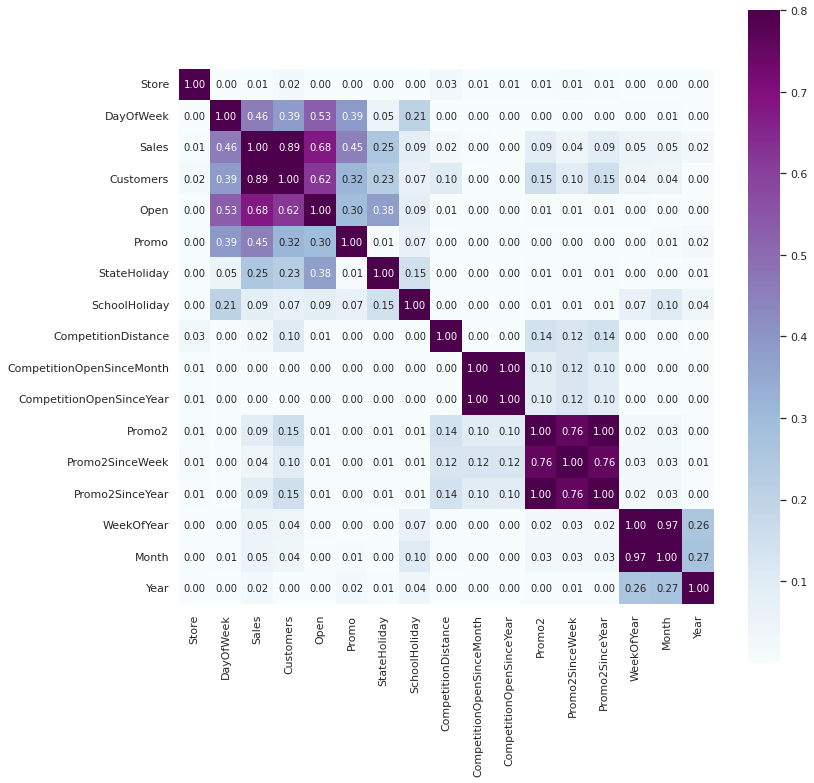

In [ ]:
# generate a correlation matrix using all the numerical features in the dataframe
corr_mat = rossmann_df.corr().abs()

# plot heatmap using correlation matrix
fig, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.2f', annot_kws={'size': 10},  vmax=.8, square=True, cmap="BuPu");

*   We can see that week of year and month are highly correlated, which is obvious since they represent points in the same timeframe but with different range. 
*   Customers and sales are also highly correlated because an increase in customers means that there must be an increase in sales too.
*   Competition distance is highly correlated with competition open since month and competition open since year because they are binary features and have the value of 1 only when Competition distance is not 0.
*   Promo2 is highly correlated with promo2 since week and promo2 since year because promo2 is a binary feature and promo2 since week and promo2 since year have the value of 1 only when promo2 is 1.
*   Open is moderately correlated with sales and customers because customers, who drive sales, can access shops only when the shops are open.

# Feature Engineering

In [ ]:
# exploring the head of the resultant dataframe
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeekOfYear,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9,2008,0,0,0,0,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9,2009,0,0,0,0,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4,2015,0,0,0,0,31,7,2015


## Handling Outliers

### Sales & Customers

Outlier detection for sales and customers can be done together since we have already established they have almost linear relationship. This way, detection and removal of outliers will be more convenient and accurate.

**Store Type**

Each store type records sales in different range. So it is more appropriate to detect outliers separately for each store type.

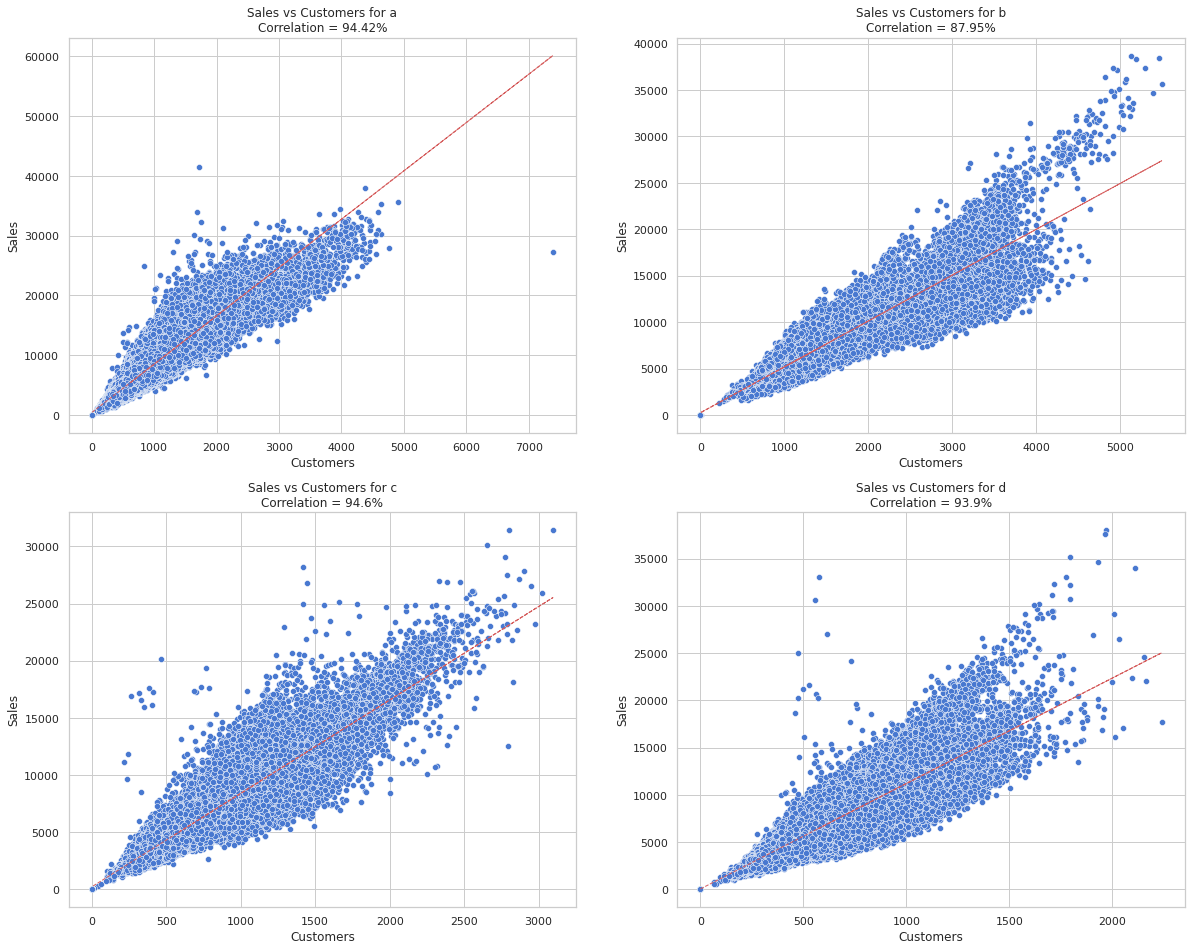

In [ ]:
# generate scatter plots to check the linearity between sales and customers for each store type
scatter_plot_bw_sales_customers_with_feature_unique_values(rossmann_df, 'StoreType')

Outliers have been identified from the scatter plot. Now lets remove them.

In [49]:
# remove outliers with respect to store types
a_filter = rossmann_df[(rossmann_df['StoreType'] == 'a') & ((rossmann_df['Sales'] > 40000) | (rossmann_df['Customers'] > 7000))].index
c_filter = rossmann_df[(rossmann_df['StoreType'] == 'c') & (((rossmann_df['Sales'] > 10000) & (rossmann_df['Customers'] < 500)) |
                                                            ((rossmann_df['Sales'] < 15000) & (rossmann_df['Customers'] > 2500)) |
                                                            ((rossmann_df['Sales'] > 25000) & (rossmann_df['Customers'] < 2000)) |
                                                             (rossmann_df['Sales'] > 30000))].index
d_filter = rossmann_df[(rossmann_df['StoreType'] == 'd') & ((rossmann_df['Sales'] > 17500) & (rossmann_df['Customers'] < 875) |
                                                            (rossmann_df['Sales'] > 31000) | (rossmann_df['Customers'] > 2000))].index

rossmann_df.drop(a_filter, inplace=True)
rossmann_df.drop(c_filter, inplace=True)
rossmann_df.drop(d_filter, inplace=True)

Now lets check if the outliers are removed

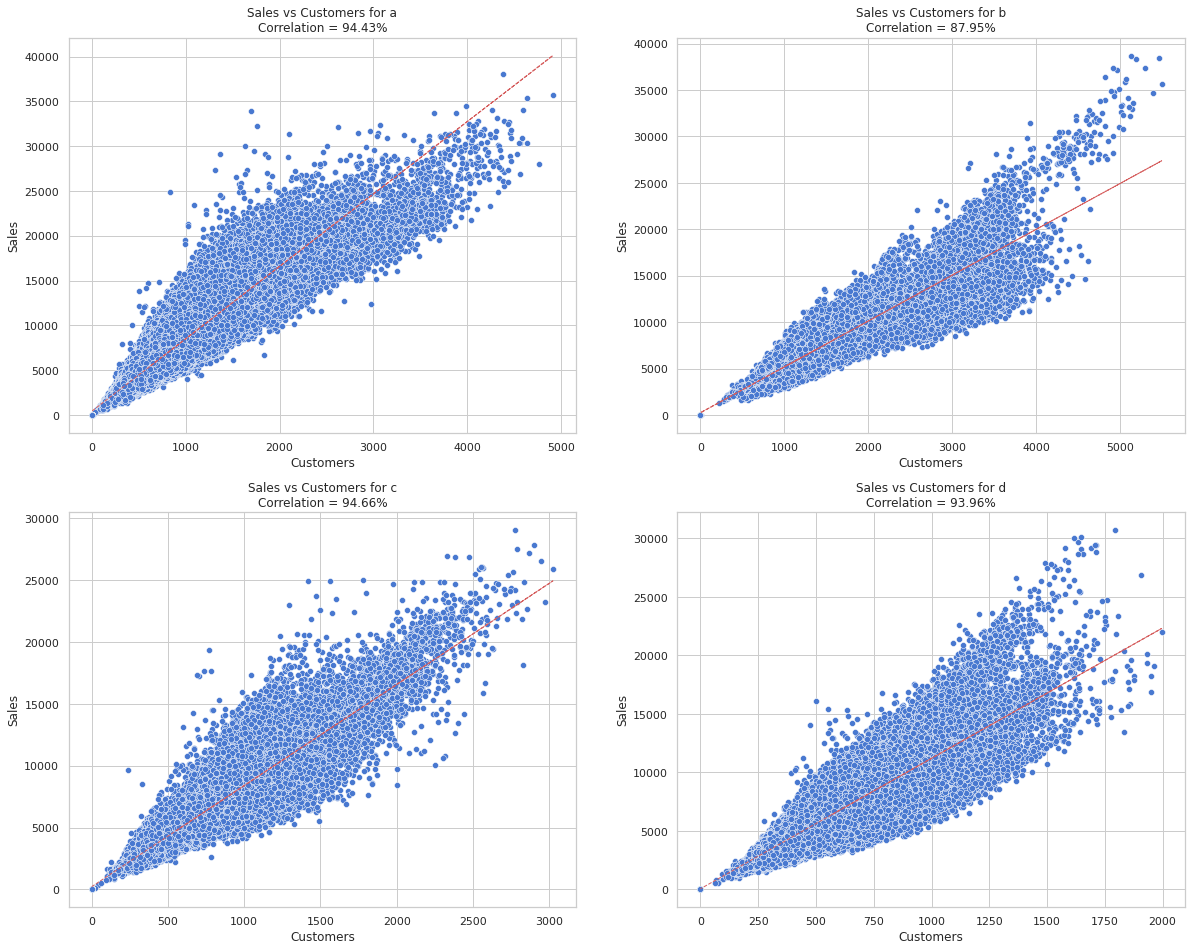

In [ ]:
# generate scatter plots to check the linearity between sales and customers for each store type
scatter_plot_bw_sales_customers_with_feature_unique_values(rossmann_df, 'StoreType')

Lets check if there is still ouliers in the data.

Outliers in sales in store type a : 14941 (2.71%)
Outliers in sales in store type b : 247 (1.56%)
Outliers in sales in store type c : 3077 (2.25%)
Outliers in sales in store type d : 5549 (1.77%)


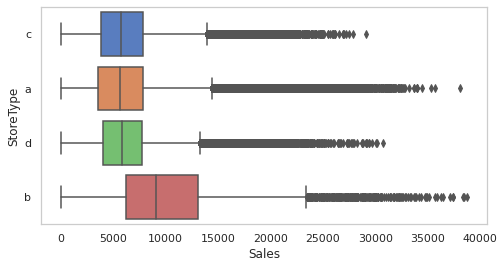

In [ ]:
# get unique values of store types
store_types = sorted(rossmann_df['StoreType'].unique().tolist())

# generate box plots of customers for each unique value in each store type
generate_horizontal_box_plot(rossmann_df, 'Sales', 'StoreType')

# count and percentage of outliers in each store type
for store_type in store_types:
  count, perc = get_outlier_count_and_percentage(rossmann_df[rossmann_df['StoreType'] == store_type], 'Sales')
  print(f"Outliers in sales in store type {store_type} : {count} ({perc}%)")

Outliers in customers in store type a : 17063 (3.09%)
Outliers in customers in store type b : 19 (0.12%)
Outliers in customers in store type c : 2884 (2.11%)
Outliers in customers in store type d : 4136 (1.32%)


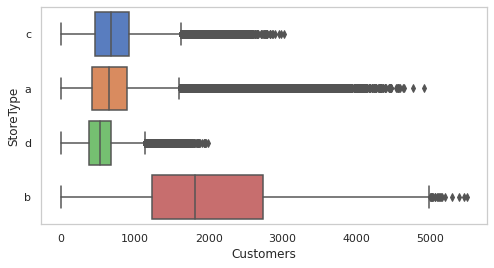

In [ ]:
# generate box plots of customers for each unique value in each store type
generate_horizontal_box_plot(rossmann_df, 'Customers', 'StoreType')

# count and percentage of outliers in each store type
for store_type in store_types:
  count, perc = get_outlier_count_and_percentage(rossmann_df[rossmann_df['StoreType'] == store_type], 'Customers')
  print(f"Outliers in customers in store type {store_type} : {count} ({perc}%)")

There are still outliers present in the data, which are detected using the above box plots. The Sales vs Customers scatter plot has been cleared of outliers and the remaining data maintains a good relationship between sales and customers. So, these outliers are just deviation from usual values and not errors in the measurement. Eliminating them can cause overfitting, so we will keep these outliers.

**Assortment**

Each assortment records sales in different range. So it is more appropriate to detect outliers separately for each assortment.

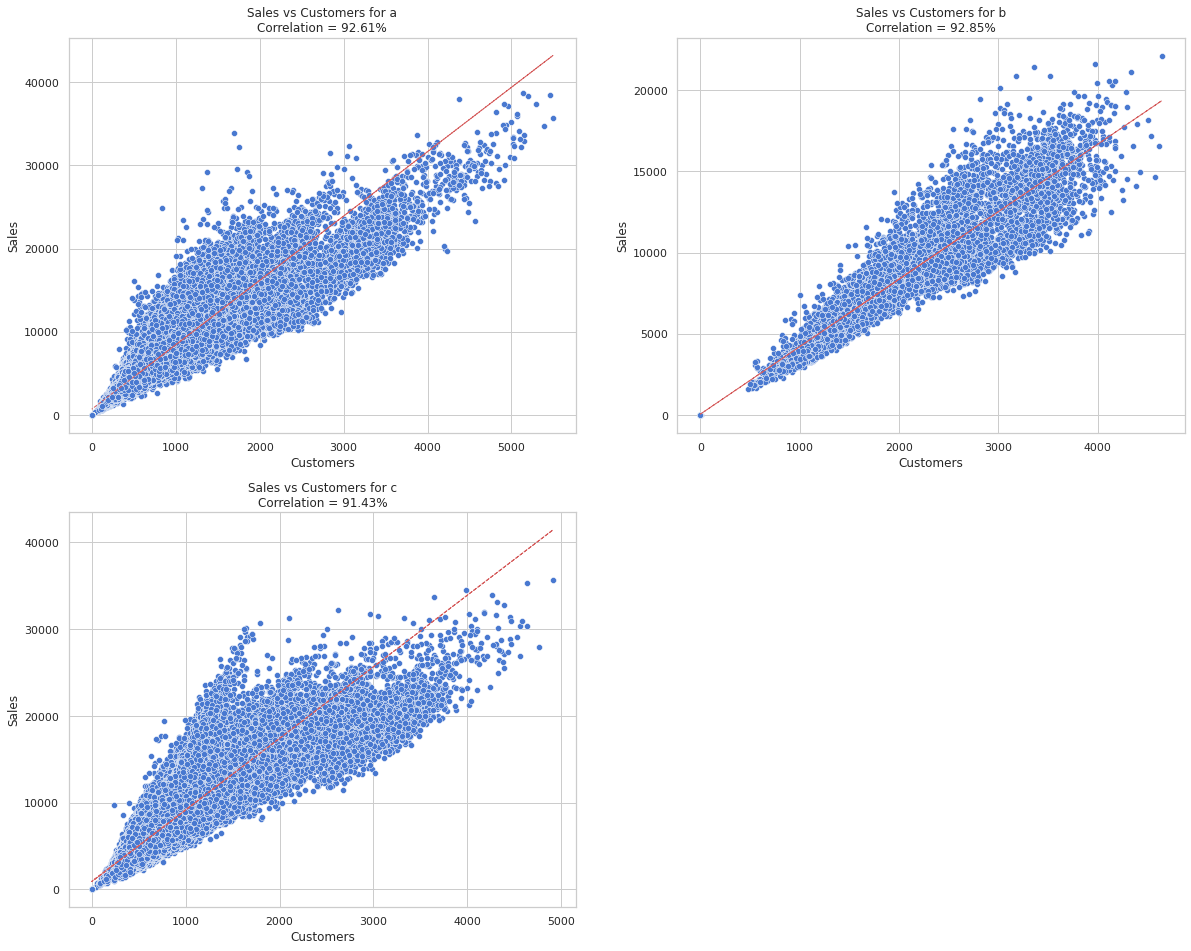

In [ ]:
# generate scatter plots to check the linearity between sales and customers for each assortment
scatter_plot_bw_sales_customers_with_feature_unique_values(rossmann_df, 'Assortment')

Outliers have been identified from the scatter plot. Now lets remove them.

In [50]:
# remove outliers with respect to assortments
a_filter = rossmann_df[(rossmann_df['Assortment'] == 'a') & (((rossmann_df['Sales'] > 20000) & (rossmann_df['Customers'] < 1000)) |
                                                             ((rossmann_df['Sales'] > 27500) & (rossmann_df['Customers'] < 2000)) |
                                                             ((rossmann_df['Sales'] > 31000) & (rossmann_df['Customers'] < 3250)) |
                                                              (rossmann_df['Sales'] > 35000))].index
rossmann_df.drop(a_filter, inplace=True)

Now lets check if the outliers are removed

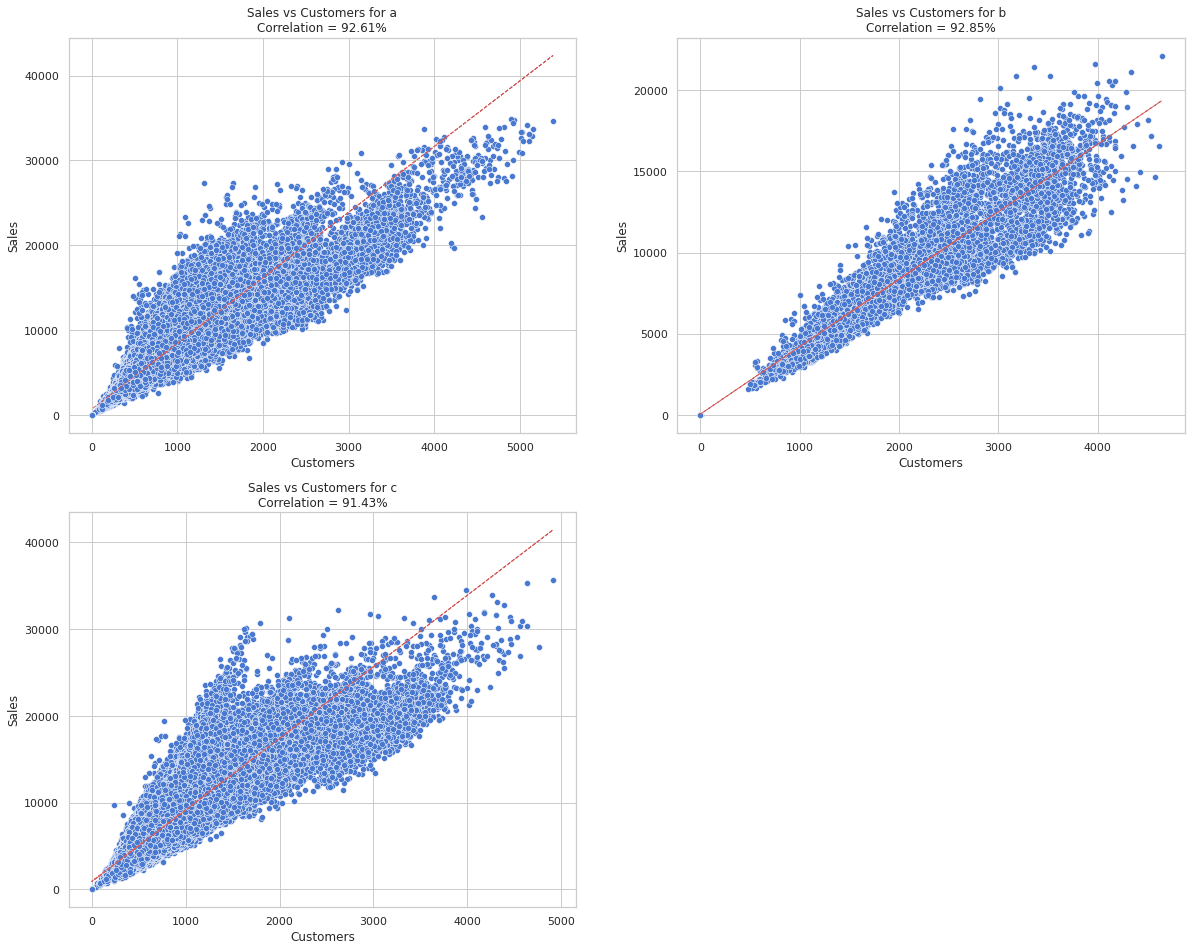

In [ ]:
# generate scatter plots to check the linearity between sales and customers for each store type
scatter_plot_bw_sales_customers_with_feature_unique_values(rossmann_df, 'Assortment')

Lets check if there is still ouliers in the data.

Outliers in sales in assortment a : 12384 (2.3%)
Outliers in sales in assortment b : 13 (0.16%)
Outliers in sales in assortment c : 13735 (2.91%)


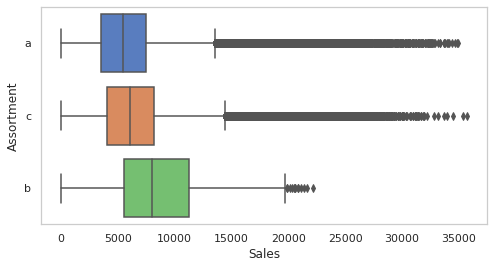

In [ ]:
# get unique values of assortment
assortments = sorted(rossmann_df['Assortment'].unique().tolist())

# generate box plots of customers for each unique value in each store type
generate_horizontal_box_plot(rossmann_df, 'Sales', 'Assortment')

# count and percentage of outliers in each store type
for assortment in assortments:
  count, perc = get_outlier_count_and_percentage(rossmann_df[rossmann_df['Assortment'] == assortment], 'Sales')
  print(f"Outliers in sales in assortment {assortment} : {count} ({perc}%)")

Outliers in customers in assortment a : 15624 (2.91%)
Outliers in customers in assortment b : 2 (0.02%)
Outliers in customers in assortment c : 17824 (3.78%)


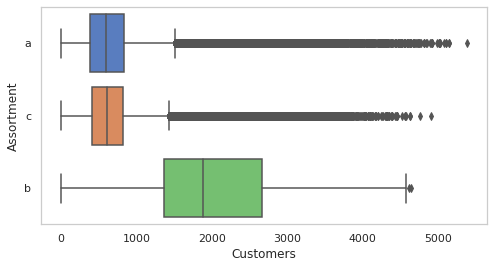

In [ ]:
# generate box plots of customers for each unique value in each store type
generate_horizontal_box_plot(rossmann_df, 'Customers', 'Assortment')

# count and percentage of outliers in each store type
for assortment in assortments:
  count, perc = get_outlier_count_and_percentage(rossmann_df[rossmann_df['Assortment'] == assortment], 'Customers')
  print(f"Outliers in customers in assortment {assortment} : {count} ({perc}%)")

There are still outliers present in the data, which are detected using the above box plots. The Sales vs Customers scatter plot has been cleared of outliers and the remaining data maintains a good relationship between sales and customers. So, these outliers are just deviation from usual values and not errors in the measurement. Eliminating them can cause overfitting, so we will keep these outliers.

### Competition Distance

Lets check for outliers in competition distance with a box plot.

Outliers in competition distance : 99158 (9.75%)


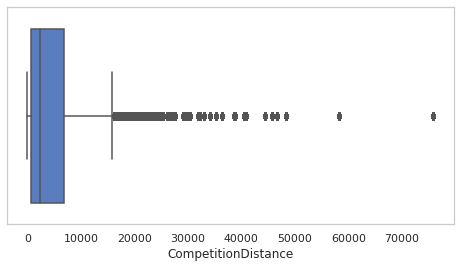

In [ ]:
# generate a box plot for competition distance
generate_horizontal_box_plot(rossmann_df, 'CompetitionDistance')

# count and percentage of outliers in competition distance
count, perc = get_outlier_count_and_percentage(rossmann_df, 'CompetitionDistance')
print(f"Outliers in competition distance : {count} ({perc}%)")

Almost 10% of data are outliers and removing them will cause the loss of useful information. What we can do is eliminate only a certain portion of outliers.

There are three options for the section of outliers that we can remove:
1. Competition distance > 55000
2. Competition distance > 44000
3. Competition distance > 37500

Lets check how much data will be removed in all of these options and decide which option to choose according to it.

In [ ]:
# count and percentage of data above different values
for limit in (55000, 44000, 37500):
  count = rossmann_df[rossmann_df['CompetitionDistance'] > limit].shape[0]
  perc = round(count/rossmann_df.shape[0]*100, 2)
  print(f"Count & percentage of data above {limit} : {count} ({perc}%)")

Count & percentage of data above 55000 : 1884 (0.19%)
Count & percentage of data above 44000 : 5652 (0.56%)
Count & percentage of data above 37500 : 9420 (0.93%)


We can choose the 3rd option since it clears the most outliers without losing much data.

In [51]:
# remove outliers with respect to store types
rossmann_df.drop(rossmann_df[rossmann_df['CompetitionDistance'] > 37500].index, inplace=True)

Outliers in competition distance : 95022 (9.43%)


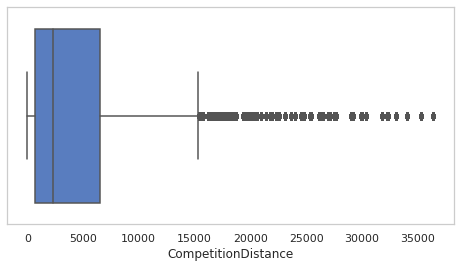

In [ ]:
# generate a box plot for competition distance
generate_horizontal_box_plot(rossmann_df, 'CompetitionDistance')

# count and percentage of outliers in competition distance
count, perc = get_outlier_count_and_percentage(rossmann_df, 'CompetitionDistance')
print(f"Outliers in competition distance : {count} ({perc}%)")

## Handling Multicollinearity

Lets find out the VIF of all features except 'Sales' in order to remove highly correlated features. Features having VIF greater than 5 should be eliminated.

In [52]:
# calculate VIF of all independant features
calculate_vif_of_all_features(rossmann_df[[column for column in rossmann_df.describe().columns if column not in ['Sales']]])

,Feature,VIF
0,Store,4.025291e+00
1,DayOfWeek,8.561418e+00
2,Customers,5.159091e+00
3,Open,1.390255e+01
4,Promo,1.997834e+00
5,StateHoliday,1.376436e+00
6,SchoolHoliday,1.333176e+00
7,CompetitionDistance,1.693158e+00
8,CompetitionOpenSinceMonth,2.767799e+03
9,CompetitionOpenSinceYear,7.280618e+03


The VIF of Promo2 and Promo2SinceYear is very high. To decide which feature to remove, lets check the correlation of both of them to Sales.

In [53]:
# find the correlation between Promo2, Promo2SinceYear & Sales
rossmann_df.loc[:, ['Promo2', 'Promo2SinceYear', 'Sales']].corr().abs()

,Promo2,Promo2SinceYear,Sales
Promo2,1.000000,0.999999,0.091904
Promo2SinceYear,0.999999,1.000000,0.091920
Sales,0.091904,0.091920,1.000000


Both have almost same correlation to Sales. Since Promo2 is a more important feature, Promo2SinceYear is removed.

In [54]:
# drop Promo2SinceYear
rossmann_df.drop('Promo2SinceYear', axis=1, inplace=True)

In [55]:
# calculate VIF of all independant features
calculate_vif_of_all_features(rossmann_df[[column for column in rossmann_df.describe().columns if column not in ['Sales']]])

,Feature,VIF
0,Store,4.021508
1,DayOfWeek,8.561396
2,Customers,5.157262
3,Open,13.901908
4,Promo,1.997804
5,StateHoliday,1.376417
6,SchoolHoliday,1.333163
7,CompetitionDistance,1.685257
8,CompetitionOpenSinceMonth,2766.490434
9,CompetitionOpenSinceYear,7276.862346


Year can be removed since it has a very high value of VIF.

In [56]:
# drop Year
rossmann_df.drop('Year', axis=1, inplace=True)

In [57]:
# calculate VIF of all independant features
calculate_vif_of_all_features(rossmann_df[[column for column in rossmann_df.describe().columns if column not in ['Sales']]])

,Feature,VIF
0,Store,4.007869
1,DayOfWeek,8.544673
2,Customers,5.146271
3,Open,13.899702
4,Promo,1.997746
5,StateHoliday,1.375752
6,SchoolHoliday,1.333139
7,CompetitionDistance,1.680742
8,CompetitionOpenSinceMonth,9.803585
9,CompetitionOpenSinceYear,23.553640


The VIF of WeekOfYear and Month is high. To decide which feature to remove, lets check the correlation of both of them to Sales.

In [58]:
# find the correlation between WeekOfYear, Month & Sales
rossmann_df.loc[:, ['WeekOfYear', 'Month', 'Sales']].corr().abs()

,WeekOfYear,Month,Sales
WeekOfYear,1.000000,0.967045,0.052212
Month,0.967045,1.000000,0.048027
Sales,0.052212,0.048027,1.000000


Month has less correlation to Sales. Therefore, it is removed.

In [59]:
# drop Month
rossmann_df.drop('Month', axis=1, inplace=True)

In [60]:
# calculate VIF of all independant features
calculate_vif_of_all_features(rossmann_df[[column for column in rossmann_df.describe().columns if column not in ['Sales']]])

,Feature,VIF
0,Store,4.007868
1,DayOfWeek,8.543702
2,Customers,5.145433
3,Open,13.887181
4,Promo,1.992631
5,StateHoliday,1.374846
6,SchoolHoliday,1.307102
7,CompetitionDistance,1.680727
8,CompetitionOpenSinceMonth,9.643647
9,CompetitionOpenSinceYear,23.134875


CompetitionOpenSinceYear can be removed since it has a high value of VIF.

In [61]:
# drop CompetitionOpenSinceYear
rossmann_df.drop('CompetitionOpenSinceYear', axis=1, inplace=True)

In [62]:
# calculate VIF of all independant features
calculate_vif_of_all_features(rossmann_df[[column for column in rossmann_df.describe().columns if column not in ['Sales']]])

,Feature,VIF
0,Store,3.685230
1,DayOfWeek,3.601370
2,Customers,5.121890
3,Open,8.762385
4,Promo,1.917402
5,StateHoliday,1.172033
6,SchoolHoliday,1.295688
7,CompetitionDistance,1.640253
8,CompetitionOpenSinceMonth,1.572158
9,Promo2,4.800416


Open can be removed since it has a high value of VIF.

In [63]:
# drop Open
rossmann_df.drop('Open', axis=1, inplace=True)

In [64]:
# calculate VIF of all independant features
calculate_vif_of_all_features(rossmann_df[[column for column in rossmann_df.describe().columns if column not in ['Sales']]])

,Feature,VIF
0,Store,3.522007
1,DayOfWeek,3.596078
2,Customers,2.941442
3,Promo,1.861268
4,StateHoliday,1.103159
5,SchoolHoliday,1.276445
6,CompetitionDistance,1.548793
7,CompetitionOpenSinceMonth,1.564822
8,Promo2,4.619795
9,Promo2SinceWeek,3.754908


Now all features have VIF less than 5.

## Feature Transformation

Scaling of numerical features is important because linear regression performs better when features are relatively on a similar scale and close to Normal Distribution.

Lets check whether all important numerical features have a normal distribution.

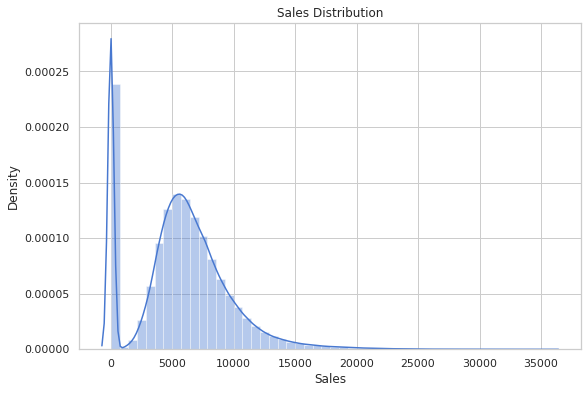

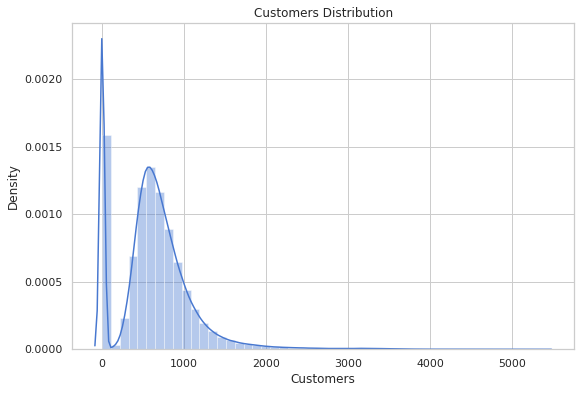

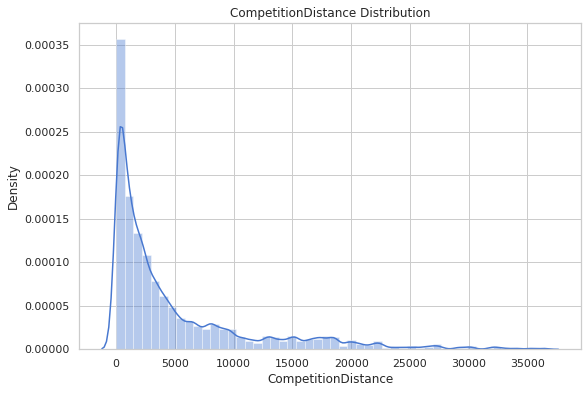

In [ ]:
# numerical features
numerical_features = ['Sales', 'Customers', 'CompetitionDistance']

# generate distribution plot for numerical features
for feature in numerical_features:
  plt.figure(figsize=(9, 6))
  sns.distplot(rossmann_df[feature]).set(title=f'{feature} Distribution')
  plt.show()

All these features are positively skewed but linear regression assumes normal distribution. So, they must be transformed to normal distribution before forecasting sales. 

Sales and customers distribution is moderately skewed and competition distance is highly skewed. So sales and customers are square root transformed and competition distance is log transformed.

In [66]:
# square root transformation of sales and customers
rossmann_df['Sales'] = np.sqrt(rossmann_df['Sales'])
rossmann_df['Customers'] = np.sqrt(rossmann_df['Customers'])

# log transformation of competition distance
rossmann_df['CompetitionDistance'] = np.log(rossmann_df['CompetitionDistance'])

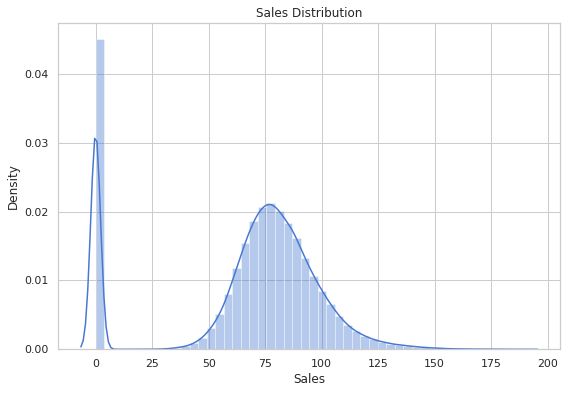

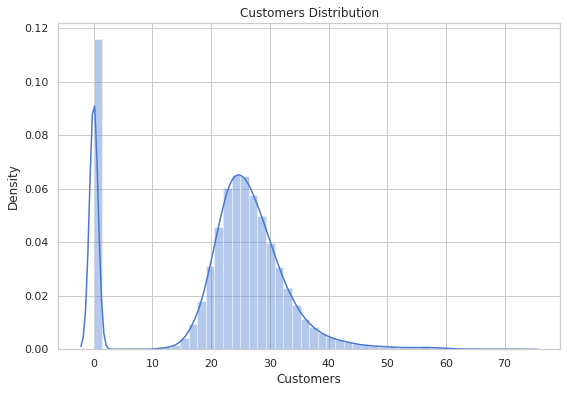

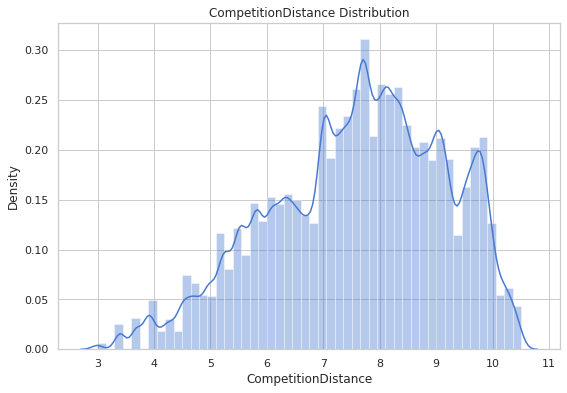

In [ ]:
# numerical features
numerical_features = ['Sales', 'Customers', 'CompetitionDistance']

# generate distribution plot for numerical features
for feature in numerical_features:
  plt.figure(figsize=(9, 6))
  sns.distplot(rossmann_df[feature]).set(title=f'{feature} Distribution')
  plt.show()

In [ ]:
# exploring the head of the resultant dataframe
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,PromoInterval,WeekOfYear
0,1,5,2015-07-31,72.546537,23.558438,1,1,0,1,c,a,7.146772,9,0,0,0,31
1,2,5,2015-07-31,77.871689,25.000000,1,1,0,1,a,a,6.345636,11,1,13,"Jan,Apr,Jul,Oct",31
2,3,5,2015-07-31,91.181138,28.653098,1,1,0,1,a,a,9.556055,12,1,14,"Jan,Apr,Jul,Oct",31
3,4,5,2015-07-31,118.300465,38.704005,1,1,0,1,c,c,6.429719,9,0,0,0,31
4,5,5,2015-07-31,69.440622,23.643181,1,1,0,1,a,a,10.305948,4,0,0,0,31


## Feature Conversion

### Remove Unnecessary Columns

Lets remove store since sales can be predicted through store type, assortment, etc.

In [67]:
# drop Store
rossmann_df.drop('Store', axis=1, inplace=True)

Lets remove date since there is already day of week and week of year features in the dataset.

In [68]:
# drop Date
rossmann_df.drop('Date', axis=1, inplace=True)

Lets also remove customers since the number of customers for the period, which is under consideration for forecasting, won't be available until the mentioned period is over.

In [69]:
# drop Customers
rossmann_df.drop('Customers', axis=1, inplace=True)

### Encoding Categorical Features

Most algorithms cannot handle the categorical variables unless they are converted into a numerical value. So, lets encode StoreType, Assortment & PromoInterval.

In [70]:
# dummying promo interval
rossmann_df = pd.get_dummies(rossmann_df, columns=['PromoInterval'])

In [71]:
# one hot encoding store type and assortment
ohe = OneHotEncoder(sparse=False, dtype=int)
ohe.fit(rossmann_df[['StoreType', 'Assortment']])
encoded_features = list(ohe.get_feature_names(['StoreType', 'Assortment']))
rossmann_df[encoded_features] = ohe.transform(rossmann_df[['StoreType', 'Assortment']])
rossmann_df.drop(['StoreType', 'Assortment'], axis=1, inplace=True)

In [72]:
# exploring the head of the resultant dataframe
rossmann_df.head()

,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,WeekOfYear,...,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,5,8.517425,1,0,1,1.966661,9,0,0,31,...,0,0,0,0,0,1,0,1,0,0
1,5,8.824494,1,0,1,1.847767,11,1,13,31,...,0,1,0,1,0,0,0,1,0,0
2,5,9.548882,1,0,1,2.257175,12,1,14,31,...,0,1,0,1,0,0,0,1,0,0
3,5,10.876602,1,0,1,1.860931,9,0,0,31,...,0,0,0,0,0,1,0,0,0,1
4,5,8.333104,1,0,1,2.332721,4,0,0,31,...,0,0,0,1,0,0,0,1,0,0


To overcome dummy variable trap, one resultant feature from each encoded feature must be removed. We can use correlation matrix to decide which features to remove.

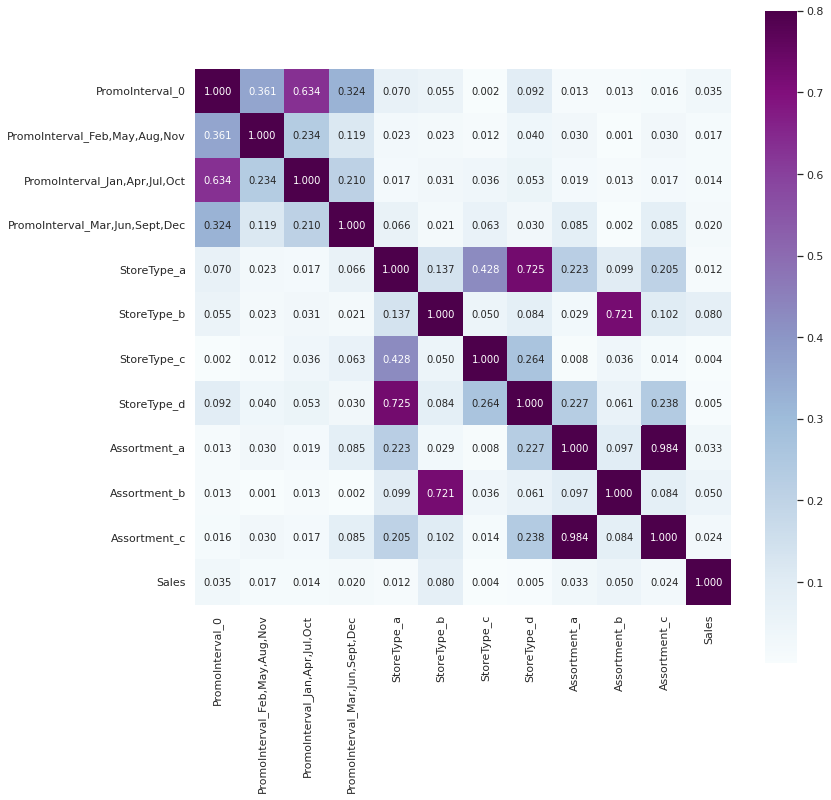

In [73]:
# find the correlation between encoded features & Sales
corr_mat = rossmann_df.loc[:, ['PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec', 
                               'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Sales']].corr().abs()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.3f', annot_kws={'size': 10},  vmax=.8, square=True, cmap="BuPu");

PromoInterval_Jan,Apr,Jul,Oct, StoreType_c & Assortment_b has the least correlation to Sales. So, they are removed.

In [74]:
# drop PromoInterval_Jan,Apr,Jul,Oct, StoreType_c & Assortment_b
rossmann_df.drop(['PromoInterval_Jan,Apr,Jul,Oct', 'StoreType_c', 'Assortment_b'], axis=1, inplace=True)

In [75]:
# exploring the head of the resultant dataframe
rossmann_df.head()

,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,WeekOfYear,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",StoreType_a,StoreType_b,StoreType_d,Assortment_a,Assortment_c
0,5,8.517425,1,0,1,1.966661,9,0,0,31,1,0,0,0,0,0,1,0
1,5,8.824494,1,0,1,1.847767,11,1,13,31,0,0,0,1,0,0,1,0
2,5,9.548882,1,0,1,2.257175,12,1,14,31,0,0,0,1,0,0,1,0
3,5,10.876602,1,0,1,1.860931,9,0,0,31,1,0,0,0,0,0,0,1
4,5,8.333104,1,0,1,2.332721,4,0,0,31,1,0,0,1,0,0,1,0


# Modelling

## Train-Test Split

First, we will separate input features and target feature.

In [104]:
# independant features (input)
X = rossmann_df.loc[:, rossmann_df.columns != 'Sales']

# dependant feature (target)
y = rossmann_df['Sales']

Now, lets split them into training and test data with 25% test data.

In [105]:
# split the datasets to training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(755787, 17)
(251929, 17)


In [106]:
# create a dataframe to store metrics related to models
metrics_table = pd.DataFrame(columns=['Regression_Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_RMSPE', 'Test_RMSPE'])

## Model Training

### Linear Regression

In [119]:
# train data with linear regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# predict the train and test data
y_train_pred_linear_reg = linear_reg.predict(X_train)
y_test_pred_linear_reg = linear_reg.predict(X_test)

In [137]:
# model evaluation
model_evaluation_linear_reg = calculate_model_metrics(y_train, y_train_pred_linear_reg, y_test, y_test_pred_linear_reg)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation_linear_reg['Train_R2']}\nRMSE  : {model_evaluation_linear_reg['Train_RMSE']}\nRMSPE : {model_evaluation_linear_reg['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation_linear_reg['Test_R2']}\nRMSE  : {model_evaluation_linear_reg['Test_RMSE']}\nRMSPE : {model_evaluation_linear_reg['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Linear', model_evaluation_linear_reg['Train_R2'], model_evaluation_linear_reg['Test_R2'], 
                                                         model_evaluation_linear_reg['Train_RMSE'], model_evaluation_linear_reg['Test_RMSE'], 
                                                         model_evaluation_linear_reg['Train_RMSPE'], model_evaluation_linear_reg['Test_RMSPE']]

Training Data
R2    : 0.49701031508042137
RMSE  : 2.473461399012692
RMSPE : 33.20380116821853%

Testing Data
R2    : 0.49567032820055545
RMSE  : 2.4728070818921966
RMSPE : 33.16235996794711%


In [121]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred_linear_reg), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,9.109442,8.597368
1,9.962034,7.763976
2,8.670244,7.970956
3,8.521468,8.163212
4,9.127906,5.622419
...,...,...
251924,9.865042,7.255497
251925,0.000000,4.154894
251926,8.248440,6.291500
251927,8.926048,9.853704


### Ridge Regression

In [122]:
# train data with ridge regression
ridge = Ridge()
parameters = {'alpha':[1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5]}

# GridSearchCV is used for hyperparameter tuning because Ridge() have only one hyperparameter
# cv=3 since dataset is large
ridge_reg = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for ridge regression: ")
for key, value in ridge_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {ridge_reg.best_score_}")

# predict the train and test data
y_train_pred_ridge_reg = ridge_reg.predict(X_train)
y_test_pred_ridge_reg = ridge_reg.predict(X_test)

The best parameters for ridge regression: 
alpha=1

Negative mean squared error: -6.118338884783532


In [138]:
# model evaluation
model_evaluation_ridge_reg = calculate_model_metrics(y_train, y_train_pred_ridge_reg, y_test, y_test_pred_ridge_reg)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation_ridge_reg['Train_R2']}\nRMSE  : {model_evaluation_ridge_reg['Train_RMSE']}\nRMSPE : {model_evaluation_ridge_reg['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation_ridge_reg['Test_R2']}\nRMSE  : {model_evaluation_ridge_reg['Test_RMSE']}\nRMSPE : {model_evaluation_ridge_reg['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Ridge', model_evaluation_ridge_reg['Train_R2'], model_evaluation_ridge_reg['Test_R2'], 
                                                        model_evaluation_ridge_reg['Train_RMSE'], model_evaluation_ridge_reg['Test_RMSE'], 
                                                        model_evaluation_ridge_reg['Train_RMSPE'], model_evaluation_ridge_reg['Test_RMSPE']]

Training Data
R2    : 0.4970103144818516
RMSE  : 2.4734614004844317
RMSPE : 33.2038011879752%

Testing Data
R2    : 0.49567036794274466
RMSE  : 2.472806984461117
RMSPE : 33.162358661316865%


In [124]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred_ridge_reg), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,9.109442,8.597352
1,9.962034,7.763967
2,8.670244,7.970961
3,8.521468,8.163198
4,9.127906,5.622416
...,...,...
251924,9.865042,7.255487
251925,0.000000,4.154887
251926,8.248440,6.291503
251927,8.926048,9.853717


### Lasso Regression

In [125]:
# train data with lasso regression
lasso = Lasso()
parameters = {'alpha':[1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5]}

# GridSearchCV is used for hyperparameter tuning because Ridge() have only one hyperparameter
# cv=3 since dataset is large
lasso_reg = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=3)
lasso_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for lasso regression: ")
for key, value in lasso_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {lasso_reg.best_score_}")

# predict the train and test data
y_train_pred_lasso_reg = lasso_reg.predict(X_train)
y_test_pred_lasso_reg = lasso_reg.predict(X_test)

The best parameters for lasso regression: 
alpha=1e-08

Negative mean squared error: -6.118338941737892


In [139]:
# model evaluation
model_evaluation_lasso_reg = calculate_model_metrics(y_train, y_train_pred_lasso_reg, y_test, y_test_pred_lasso_reg)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation_lasso_reg['Train_R2']}\nRMSE  : {model_evaluation_lasso_reg['Train_RMSE']}\nRMSPE : {model_evaluation_lasso_reg['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation_lasso_reg['Test_R2']}\nRMSE  : {model_evaluation_lasso_reg['Test_RMSE']}\nRMSPE : {model_evaluation_lasso_reg['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Lasso', model_evaluation_lasso_reg['Train_R2'], model_evaluation_lasso_reg['Test_R2'], 
                                                        model_evaluation_lasso_reg['Train_RMSE'], model_evaluation_lasso_reg['Test_RMSE'], 
                                                        model_evaluation_lasso_reg['Train_RMSPE'], model_evaluation_lasso_reg['Test_RMSPE']]

Training Data
R2    : 0.4970103150804057
RMSE  : 2.4734613990127308
RMSPE : 33.20380116821905%

Testing Data
R2    : 0.49567032857457527
RMSE  : 2.4728070809752576
RMSPE : 33.16235995565021%


In [127]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred_lasso_reg), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,9.109442,8.597368
1,9.962034,7.763976
2,8.670244,7.970956
3,8.521468,8.163212
4,9.127906,5.622419
...,...,...
251924,9.865042,7.255497
251925,0.000000,4.154894
251926,8.248440,6.291500
251927,8.926048,9.853705


### Elastic Net Regression

In [128]:
# train data with elastic net regression
elastic_net = ElasticNet()
parameters = {'alpha':[1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5],'l1_ratio':[0.3,0.4,0.5,0.6,0.7]}

# GridSearchCV is used for hyperparameter tuning because Ridge() have only two hyperparameters
# cv=3 since dataset is large
elastic_net_reg = GridSearchCV(elastic_net, parameters, scoring='neg_mean_squared_error', cv=3)
elastic_net_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for elastic net regression: ")
for key, value in elastic_net_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {elastic_net_reg.best_score_}")

# predict the train and test data
y_train_pred_elastic_net_reg = elastic_net_reg.predict(X_train)
y_test_pred_elastic_net_reg = elastic_net_reg.predict(X_test)

The best parameters for elastic net regression: 
alpha=1e-08
l1_ratio=0.3

Negative mean squared error: -6.118338941506873


In [140]:
# model evaluation
model_evaluation_elastic_net_reg = calculate_model_metrics(y_train, y_train_pred_elastic_net_reg, y_test, y_test_pred_elastic_net_reg)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation_elastic_net_reg['Train_R2']}\nRMSE  : {model_evaluation_elastic_net_reg['Train_RMSE']}\nRMSPE : {model_evaluation_elastic_net_reg['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation_elastic_net_reg['Test_R2']}\nRMSE  : {model_evaluation_elastic_net_reg['Test_RMSE']}\nRMSPE : {model_evaluation_elastic_net_reg['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Elastic Net', model_evaluation_elastic_net_reg['Train_R2'], model_evaluation_elastic_net_reg['Test_R2'], 
                                                              model_evaluation_elastic_net_reg['Train_RMSE'], model_evaluation_elastic_net_reg['Test_RMSE'], 
                                                              model_evaluation_elastic_net_reg['Train_RMSPE'], model_evaluation_elastic_net_reg['Test_RMSPE']]

Training Data
R2    : 0.49701031508039584
RMSE  : 2.473461399012755
RMSPE : 33.203801168219385%

Testing Data
R2    : 0.4956703285270637
RMSE  : 2.472807081091736
RMSPE : 33.16235995721228%


In [130]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred_elastic_net_reg), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,9.109442,8.597368
1,9.962034,7.763976
2,8.670244,7.970956
3,8.521468,8.163212
4,9.127906,5.622419
...,...,...
251924,9.865042,7.255497
251925,0.000000,4.154894
251926,8.248440,6.291500
251927,8.926048,9.853705


### Decision Tree Regression

In [113]:
# train data with decision tree regression
decision_tree = DecisionTreeRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because DecisionTreeRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
dt_reg = RandomizedSearchCV(estimator=decision_tree, param_distributions=parameters, n_iter=10, cv=3)
dt_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for decision tree regression: ")
for key, value in dt_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {dt_reg.best_score_}")

# predict the train and test data
y_train_pred_dt_reg = dt_reg.predict(X_train)
y_test_pred_dt_reg = dt_reg.predict(X_test)

The best parameters for decision tree regression: 
min_samples_split=2
min_samples_leaf=1
max_leaf_nodes=100
max_features=auto
max_depth=5

Negative mean squared error: 0.9332942820137217


In [141]:
# model evaluation
model_evaluation_dt_reg = calculate_model_metrics(y_train, y_train_pred_dt_reg, y_test, y_test_pred_dt_reg)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation_dt_reg['Train_R2']}\nRMSE  : {model_evaluation_dt_reg['Train_RMSE']}\nRMSPE : {model_evaluation_dt_reg['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation_dt_reg['Test_R2']}\nRMSE  : {model_evaluation_dt_reg['Test_RMSE']}\nRMSPE : {model_evaluation_dt_reg['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Decision Tree', model_evaluation_dt_reg['Train_R2'], model_evaluation_dt_reg['Test_R2'], 
                                                                model_evaluation_dt_reg['Train_RMSE'], model_evaluation_dt_reg['Test_RMSE'], 
                                                                model_evaluation_dt_reg['Train_RMSPE'], model_evaluation_dt_reg['Test_RMSPE']]

Training Data
R2    : 0.9334502822761439
RMSE  : 0.8997020428200115
RMSPE : 12.077620355167067%

Testing Data
R2    : 0.9344430226113634
RMSE  : 0.8915432914949618
RMSPE : 11.956322745946123%


In [115]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred_dt_reg), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,9.109442,8.713920
1,9.962034,9.242053
2,8.670244,8.442361
3,8.521468,8.713920
4,9.127906,8.713920
...,...,...
251924,9.865042,9.242053
251925,0.000000,0.114357
251926,8.248440,8.442361
251927,8.926048,8.713920


### Random Forest Regression

In [116]:
# train data with random forest regression
random_forest = RandomForestRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because RandomForestRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
rf_reg = RandomizedSearchCV(estimator=random_forest, param_distributions=parameters, n_iter=10, cv=3)
rf_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for random forest regression: ")
for key, value in rf_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {rf_reg.best_score_}")

# predict the train and test data
y_train_pred_rf_reg = rf_reg.predict(X_train)
y_test_pred_rf_reg = rf_reg.predict(X_test)

The best parameters for random forest regression: 
min_samples_split=2
min_samples_leaf=1
max_leaf_nodes=100
max_features=auto
max_depth=10

Negative mean squared error: 0.9434032485982691


In [142]:
# model evaluation
model_evaluation_rf_reg = calculate_model_metrics(y_train, y_train_pred_rf_reg, y_test, y_test_pred_rf_reg)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation_rf_reg['Train_R2']}\nRMSE  : {model_evaluation_rf_reg['Train_RMSE']}\nRMSPE : {model_evaluation_rf_reg['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation_rf_reg['Test_R2']}\nRMSE  : {model_evaluation_rf_reg['Test_RMSE']}\nRMSPE : {model_evaluation_rf_reg['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Random Forest', model_evaluation_rf_reg['Train_R2'], model_evaluation_rf_reg['Test_R2'], 
                                                                model_evaluation_rf_reg['Train_RMSE'], model_evaluation_rf_reg['Test_RMSE'], 
                                                                model_evaluation_rf_reg['Train_RMSPE'], model_evaluation_rf_reg['Test_RMSPE']]

Training Data
R2    : 0.943309607385295
RMSE  : 0.8303865957164571
RMSPE : 11.147128242198871%

Testing Data
R2    : 0.9441510739960576
RMSE  : 0.822887354843758
RMSPE : 11.035590634720693%


In [118]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred_rf_reg), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,9.109442,8.424209
1,9.962034,9.703217
2,8.670244,8.728117
3,8.521468,8.698641
4,9.127906,8.752460
...,...,...
251924,9.865042,9.364172
251925,0.000000,0.036240
251926,8.248440,8.574996
251927,8.926048,8.604368


### XGBoost Regression

In [134]:
# train data with XGBoost regression
xgboost = xgb.XGBRegressor(objective ='reg:linear', verbosity = 0)
parameters = {'max_depth': [2, 5, 10],
              'learning_rate': [0.05, 0.1, 0.2],
              'min_child_weight': [1, 2, 5],
              'gamma': [0, 0.1, 0.3],
              'colsample_bytree': [0.3, 0.5, 0.7]}

# RandomizedSearchCV is used for hyperparameter tuning because XGBRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
xg_reg = RandomizedSearchCV(estimator=xgboost, param_distributions=parameters, n_iter=10, cv=3)
xg_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for XGBoost regression: ")
for key, value in xg_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {xg_reg.best_score_}")

# predict the train and test data
y_train_pred_xg_reg = xg_reg.predict(X_train)
y_test_pred_xg_reg = xg_reg.predict(X_test)

The best parameters for XGBoost regression: 
min_child_weight=5
max_depth=10
learning_rate=0.2
gamma=0.1
colsample_bytree=0.7

Negative mean squared error: 0.976700390331218


In [143]:
# model evaluation
model_evaluation_xg_reg = calculate_model_metrics(y_train, y_train_pred_xg_reg, y_test, y_test_pred_xg_reg)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation_xg_reg['Train_R2']}\nRMSE  : {model_evaluation_xg_reg['Train_RMSE']}\nRMSPE : {model_evaluation_xg_reg['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation_xg_reg['Test_R2']}\nRMSE  : {model_evaluation_xg_reg['Test_RMSE']}\nRMSPE : {model_evaluation_xg_reg['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['XGBoost', model_evaluation_xg_reg['Train_R2'], model_evaluation_xg_reg['Test_R2'], 
                                                          model_evaluation_xg_reg['Train_RMSE'], model_evaluation_xg_reg['Test_RMSE'], 
                                                          model_evaluation_xg_reg['Train_RMSPE'], model_evaluation_xg_reg['Test_RMSPE']]

Training Data
R2    : 0.9794068309127262
RMSE  : 0.500480534000788
RMSPE : 6.718461887522962%

Testing Data
R2    : 0.9784773235458156
RMSE  : 0.510835551462328
RMSPE : 6.850721419422488%


In [136]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred_xg_reg), columns = ['actual', 'pred'])
regression_Dataframe

,actual,pred
0,9.109442,8.957278
1,9.962034,9.753630
2,8.670244,8.231613
3,8.521468,8.628858
4,9.127906,9.052732
...,...,...
251924,9.865042,9.950020
251925,0.000000,-0.059865
251926,8.248440,8.587908
251927,8.926048,8.937467


## Model Comparison

In [144]:
# print metrics table
metrics_table

,Regression_Model,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_RMSPE,Test_RMSPE
0,Linear,0.497010,0.495670,2.473461,2.472807,33.203801,33.162360
1,Ridge,0.497010,0.495670,2.473461,2.472807,33.203801,33.162359
2,Lasso,0.497010,0.495670,2.473461,2.472807,33.203801,33.162360
3,Elastic Net,0.497010,0.495670,2.473461,2.472807,33.203801,33.162360
4,Decision Tree,0.933450,0.934443,0.899702,0.891543,12.077620,11.956323
5,Random Forest,0.943310,0.944151,0.830387,0.822887,11.147128,11.035591
6,XGBoost,0.979407,0.978477,0.500481,0.510836,6.718462,6.850721


R2 score can be used to compare different models and find out which one gives higher accuracy. Higher the R2 score, higher the accuracy.

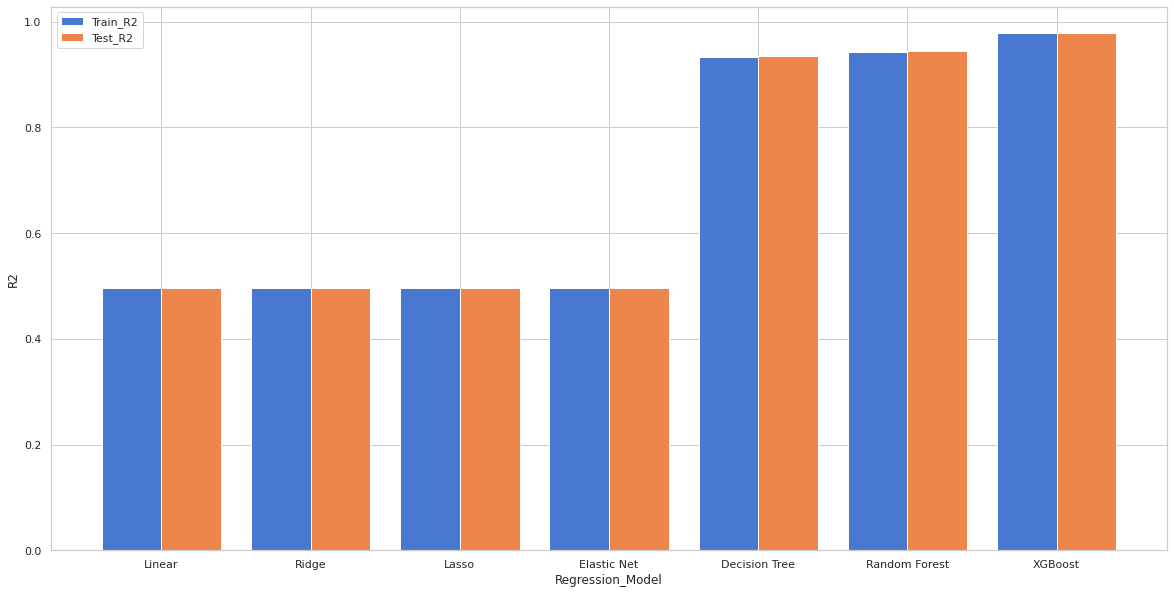

In [145]:
plot_bar_graph_with_three_features(metrics_table, 'Regression_Model', 'Train_R2', 'Test_R2', 'R2')

The model built using XGBoost algorithm has the highest R2 score, followed by the one using random forest and decision tree.

# Conclusion

### Conclusions from EDA

1. Mondays have most sales since most of the Sundays are closed.
2. Promotions seem to have a significant effect on sales but not for the number of customers. It is advisable to spend more on promos to get higher returns.
3. Store type b has higher sales and customers per store than other store types. More Store type b must be opened.
4. Assortment b is available only at store type b and it has more sales and customers than any other assortment. More assortment b must be stocked to meet the demands of customers.
5. Weekly sales and customers peak at the mid-December. It may be guessed that people buy drugs in advance just before the shops close for the holiday season.

### Conclusions from Modelling

1. The model built using XGBoost algorithm gives unusually high accuracy. This may lead to overfitting. Therefore, it is advisable to not use this model. 
2. Among the remaining, the model built using random forest algorithm is the most accurate one. This can be attributed to higher number of categorical features in the data. 
3. If model interpretability is more important than accuracy, model built using decision tree algorithm should be chosen over the one using random forest algorithm. Since the difference between accuracy of these two models is less than 1%, there won't be a large difference in the result.
4. Decision tree based algorithms are slightly more accurate than linear regression based algorithms. Decision tree based algorithm gives an accuracy of ~93% while linear regression based algorithms given ~50%.